In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/u/0/uc?id=1PUR83K9OJRr1hN_K8uUdPHqM0qr6td80&export=download"
output = "data_256.zip"
gdown.download(url, output)
!unzip data_256.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1PUR83K9OJRr1hN_K8uUdPHqM0qr6td80&export=download
From (redirected): https://drive.google.com/uc?id=1PUR83K9OJRr1hN_K8uUdPHqM0qr6td80&export=download&confirm=t&uuid=b957f64d-846e-4daa-bda6-04bf6bf0b56d
To: /content/data_256.zip
100%|██████████| 84.2M/84.2M [00:00<00:00, 90.8MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_256/clean/images/1_1695.png  
  inflating: data_256/clean/images/1_1696.png  
  inflating: data_256/clean/images/1_1697.png  
  inflating: data_256/clean/images/1_1710.png  
  inflating: data_256/clean/images/1_1711.png  
  inflating: data_256/clean/images/1_1712.png  
  inflating: data_256/clean/images/1_1714.png  
  inflating: data_256/clean/images/1_1715.png  
  inflating: data_256/clean/images/1_1716.png  
  inflating: data_256/clean/images/1_1719.png  
  inflating: data_256/clean/images/1_1723.png  
  inflating: data_256/clean/images/1_1724.png  
  inflating: data_256/clean/images/1_1726.png  
  inflating: data_256/clean/images/1_1727.png  
  inflating: data_256/clean/images/1_1728.png  
  inflating: data_256/clean/images/1_1737.png  
  inflating: data_256/clean/images/1_1741.png  
  inflating: data_256/clean/images/1_1744.png  
  inflating: data_256/clean/images/1_1745.png  
  inflating: data_256/clean/images/1_1

In [3]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_256")):
  print(folder)
  for im in tqdm(os.listdir("data_256/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:20<01:01, 20.38s/it]

jammed_channel



 50%|█████     | 2/4 [00:22<00:19,  9.88s/it]

test



 75%|███████▌  | 3/4 [00:26<00:07,  7.09s/it]

clean_validation



100%|██████████| 4/4 [00:29<00:00,  7.38s/it]


In [4]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [5]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



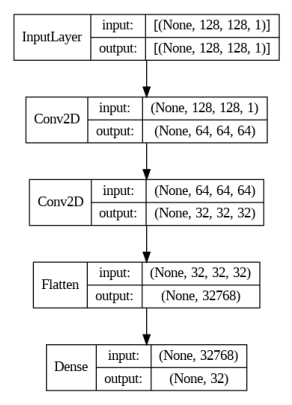

Summary of the decoder:



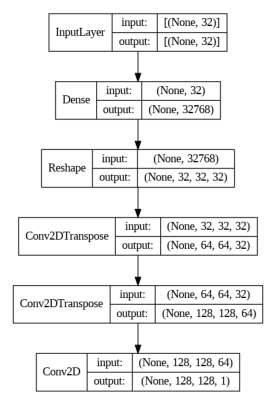

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [7]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 12s 52ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 2/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 3/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 4/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 5/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 6/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 7/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 8/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 9/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 10/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0134 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

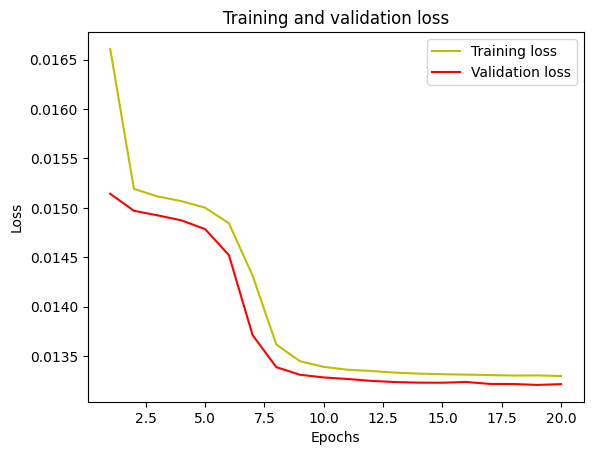

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 21ms/step


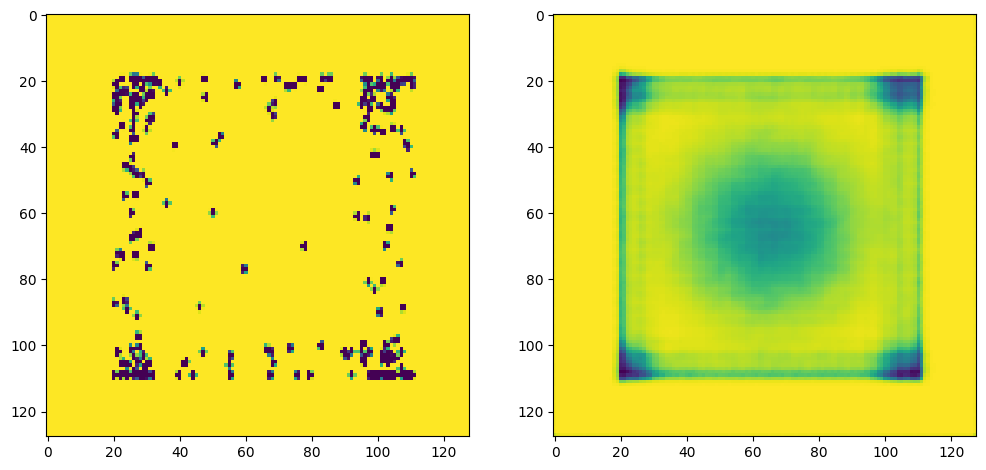

In [10]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [11]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 45ms/step - loss: 0.0185
Validation error 0.01321408897638321
Anomaly error 0.018464095890522003
The reconstruction error of the jammed channel is  1.3973037356961826  more than the clean channel


In [12]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [13]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 173ms/step - loss: 0.0130


  0%|          | 1/600 [00:00<03:35,  2.77it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0097


  0%|          | 3/600 [00:00<01:39,  6.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0097


  1%|          | 4/600 [00:00<01:26,  6.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0159


  1%|          | 6/600 [00:00<01:10,  8.40it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0091


  1%|▏         | 8/600 [00:01<01:02,  9.43it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0157


  2%|▏         | 10/600 [00:01<00:58, 10.17it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0096


  2%|▏         | 12/600 [00:01<00:57, 10.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0126


  2%|▏         | 14/600 [00:01<00:55, 10.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0156


  3%|▎         | 16/600 [00:01<00:55, 10.57it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0136


  3%|▎         | 18/600 [00:01<00:55, 10.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0091


  3%|▎         | 20/600 [00:02<00:55, 10.41it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0121


  4%|▎         | 22/600 [00:02<00:56, 10.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0154


  4%|▍         | 24/600 [00:02<00:55, 10.43it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0161


  4%|▍         | 26/600 [00:02<00:53, 10.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0151


  5%|▍         | 28/600 [00:02<00:49, 11.52it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0127


  5%|▌         | 30/600 [00:02<00:45, 12.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0100


  5%|▌         | 32/600 [00:03<00:41, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0099


  6%|▌         | 34/600 [00:03<00:39, 14.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0091


  6%|▌         | 36/600 [00:03<00:39, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0149


  6%|▋         | 38/600 [00:03<00:40, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0143


  7%|▋         | 40/600 [00:03<00:39, 14.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0137


  7%|▋         | 42/600 [00:03<00:38, 14.52it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0128


  7%|▋         | 44/600 [00:03<00:37, 14.95it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0094


  8%|▊         | 46/600 [00:04<00:35, 15.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0131


  8%|▊         | 48/600 [00:04<00:35, 15.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


  8%|▊         | 50/600 [00:04<00:35, 15.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0118


  9%|▊         | 52/600 [00:04<00:36, 14.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0160


  9%|▉         | 54/600 [00:04<00:57,  9.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0100


  9%|▉         | 56/600 [00:04<00:50, 10.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0156


 10%|▉         | 58/600 [00:05<00:44, 12.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0156


 10%|█         | 60/600 [00:05<00:43, 12.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0100


 10%|█         | 62/600 [00:05<00:42, 12.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


 11%|█         | 64/600 [00:05<00:41, 13.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0126


 11%|█         | 66/600 [00:05<00:39, 13.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0097


 11%|█▏        | 68/600 [00:05<00:38, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 12%|█▏        | 70/600 [00:05<00:37, 14.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0128


 12%|█▏        | 72/600 [00:06<00:35, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0134


 12%|█▏        | 74/600 [00:06<00:34, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0161


 13%|█▎        | 76/600 [00:06<00:33, 15.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 13%|█▎        | 78/600 [00:06<00:33, 15.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0091


 13%|█▎        | 80/600 [00:06<00:32, 15.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0101


 14%|█▎        | 82/600 [00:06<00:32, 15.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 14%|█▍        | 84/600 [00:06<00:33, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0101


 14%|█▍        | 86/600 [00:06<00:32, 15.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0162


 15%|█▍        | 88/600 [00:07<00:32, 15.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 15%|█▌        | 90/600 [00:07<00:32, 15.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0131


 15%|█▌        | 92/600 [00:07<00:33, 15.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0109


 16%|█▌        | 94/600 [00:07<00:33, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 16%|█▌        | 96/600 [00:07<00:34, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0098


 16%|█▋        | 98/600 [00:07<00:33, 14.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0150


 17%|█▋        | 100/600 [00:07<00:33, 15.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0151


 17%|█▋        | 102/600 [00:07<00:33, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0101


 17%|█▋        | 104/600 [00:08<00:32, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0092


 18%|█▊        | 106/600 [00:08<00:31, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 18%|█▊        | 108/600 [00:08<00:31, 15.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 18%|█▊        | 110/600 [00:08<00:33, 14.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0126


 19%|█▊        | 112/600 [00:08<00:34, 14.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0161


 19%|█▉        | 114/600 [00:08<00:33, 14.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0162


 19%|█▉        | 116/600 [00:08<00:33, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0155


 20%|█▉        | 118/600 [00:09<00:33, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 20%|██        | 120/600 [00:09<00:33, 14.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0164


 20%|██        | 122/600 [00:09<00:33, 14.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0100


 21%|██        | 124/600 [00:09<00:32, 14.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0123


 21%|██        | 126/600 [00:09<00:33, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0101


 21%|██▏       | 128/600 [00:09<00:31, 14.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0131


 22%|██▏       | 130/600 [00:09<00:31, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0100


 22%|██▏       | 132/600 [00:10<00:31, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0153


 22%|██▏       | 134/600 [00:10<00:30, 15.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0153


 23%|██▎       | 136/600 [00:10<00:30, 14.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0156


 23%|██▎       | 138/600 [00:10<00:30, 15.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 23%|██▎       | 140/600 [00:10<00:31, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0161


 24%|██▎       | 142/600 [00:10<00:30, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0126


 24%|██▍       | 144/600 [00:10<00:30, 15.04it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0101


 24%|██▍       | 146/600 [00:10<00:30, 14.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0163


 25%|██▍       | 148/600 [00:11<00:29, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0142


 25%|██▌       | 150/600 [00:11<00:30, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0099


 25%|██▌       | 152/600 [00:11<00:30, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0156


 26%|██▌       | 154/600 [00:11<00:30, 14.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0131


 26%|██▌       | 156/600 [00:11<00:29, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 26%|██▋       | 158/600 [00:11<00:30, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0146


 27%|██▋       | 160/600 [00:11<00:29, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0095


 27%|██▋       | 162/600 [00:12<00:28, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0137


 27%|██▋       | 164/600 [00:12<00:28, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 28%|██▊       | 166/600 [00:12<00:29, 14.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


 28%|██▊       | 168/600 [00:12<00:28, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


 28%|██▊       | 170/600 [00:12<00:28, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


 29%|██▊       | 172/600 [00:12<00:28, 14.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0098


 29%|██▉       | 174/600 [00:12<00:31, 13.63it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0131


 29%|██▉       | 176/600 [00:13<00:36, 11.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0156


 30%|██▉       | 178/600 [00:13<00:36, 11.53it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0102


 30%|███       | 180/600 [00:13<00:37, 11.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0126


 30%|███       | 182/600 [00:13<00:38, 10.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0095


 31%|███       | 184/600 [00:13<00:37, 11.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0154


 31%|███       | 186/600 [00:13<00:37, 11.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0093


 31%|███▏      | 188/600 [00:14<00:36, 11.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0120


 32%|███▏      | 190/600 [00:14<00:36, 11.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0125


 32%|███▏      | 192/600 [00:14<00:37, 10.99it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0152


 32%|███▏      | 194/600 [00:14<00:36, 10.98it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0117


 33%|███▎      | 196/600 [00:14<00:36, 11.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0165


 33%|███▎      | 198/600 [00:15<00:36, 10.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0147


 33%|███▎      | 200/600 [00:15<00:34, 11.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


 34%|███▎      | 202/600 [00:15<00:32, 12.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0160


 34%|███▍      | 204/600 [00:15<00:30, 13.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0155


 34%|███▍      | 206/600 [00:15<00:29, 13.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0101


 35%|███▍      | 208/600 [00:15<00:28, 13.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0164


 35%|███▌      | 210/600 [00:15<00:28, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 35%|███▌      | 212/600 [00:16<00:27, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0127


 36%|███▌      | 214/600 [00:16<00:26, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0113


 36%|███▌      | 216/600 [00:16<00:26, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0132


 36%|███▋      | 218/600 [00:16<00:26, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0125


 37%|███▋      | 220/600 [00:16<00:25, 14.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0099


 37%|███▋      | 222/600 [00:16<00:26, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 37%|███▋      | 224/600 [00:16<00:25, 14.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0158


 38%|███▊      | 226/600 [00:17<00:25, 14.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0097


 38%|███▊      | 228/600 [00:17<00:25, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


 38%|███▊      | 230/600 [00:17<00:25, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0145


 39%|███▊      | 232/600 [00:17<00:24, 14.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0138


 39%|███▉      | 234/600 [00:17<00:24, 14.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0151


 39%|███▉      | 236/600 [00:17<00:24, 14.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0153


 40%|███▉      | 238/600 [00:17<00:25, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0153


 40%|████      | 240/600 [00:17<00:26, 13.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 40%|████      | 242/600 [00:18<00:25, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


 41%|████      | 244/600 [00:18<00:24, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0166


 41%|████      | 246/600 [00:18<00:24, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


 41%|████▏     | 248/600 [00:18<00:24, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


 42%|████▏     | 250/600 [00:18<00:23, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0145


 42%|████▏     | 252/600 [00:18<00:24, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0135


 42%|████▏     | 254/600 [00:18<00:23, 14.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0098


 43%|████▎     | 256/600 [00:19<00:23, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0160


 43%|████▎     | 258/600 [00:19<00:23, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0155


 43%|████▎     | 260/600 [00:19<00:23, 14.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0159


 44%|████▎     | 262/600 [00:19<00:23, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0157


 44%|████▍     | 264/600 [00:19<00:23, 14.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0151


 44%|████▍     | 266/600 [00:19<00:24, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 45%|████▍     | 268/600 [00:19<00:23, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0145


 45%|████▌     | 270/600 [00:20<00:22, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0106


 45%|████▌     | 272/600 [00:20<00:22, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 46%|████▌     | 274/600 [00:20<00:22, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0155


 46%|████▌     | 276/600 [00:20<00:22, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0138


 46%|████▋     | 278/600 [00:20<00:22, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0156


 47%|████▋     | 280/600 [00:20<00:22, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 47%|████▋     | 282/600 [00:20<00:21, 14.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0152


 47%|████▋     | 284/600 [00:21<00:21, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0091


 48%|████▊     | 286/600 [00:21<00:21, 14.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0160


 48%|████▊     | 288/600 [00:21<00:21, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0136


 48%|████▊     | 290/600 [00:21<00:21, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 49%|████▊     | 292/600 [00:21<00:21, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0146


 49%|████▉     | 294/600 [00:21<00:21, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0152


 49%|████▉     | 296/600 [00:21<00:21, 14.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0099


 50%|████▉     | 298/600 [00:21<00:20, 14.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0097


 50%|█████     | 300/600 [00:22<00:20, 14.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0160


 50%|█████     | 302/600 [00:22<00:20, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0096


 51%|█████     | 304/600 [00:22<00:20, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0133


 51%|█████     | 306/600 [00:22<00:21, 13.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0117


 51%|█████▏    | 308/600 [00:22<00:20, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0151


 52%|█████▏    | 310/600 [00:22<00:20, 14.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0152


 52%|█████▏    | 312/600 [00:22<00:19, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0142


 52%|█████▏    | 314/600 [00:23<00:19, 14.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0148


 53%|█████▎    | 316/600 [00:23<00:20, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0123


 53%|█████▎    | 318/600 [00:23<00:19, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0104


 53%|█████▎    | 320/600 [00:23<00:19, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0152


 54%|█████▎    | 322/600 [00:23<00:19, 14.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0147


 54%|█████▍    | 324/600 [00:23<00:18, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 54%|█████▍    | 326/600 [00:23<00:18, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 55%|█████▍    | 328/600 [00:24<00:18, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0151


 55%|█████▌    | 330/600 [00:24<00:18, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0150


 55%|█████▌    | 332/600 [00:24<00:18, 14.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0155


 56%|█████▌    | 334/600 [00:24<00:17, 14.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0153


 56%|█████▌    | 336/600 [00:24<00:17, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0102


 56%|█████▋    | 338/600 [00:24<00:18, 14.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0144


 57%|█████▋    | 340/600 [00:24<00:18, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0109


 57%|█████▋    | 342/600 [00:25<00:17, 14.98it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0112


 57%|█████▋    | 344/600 [00:25<00:18, 13.51it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0119


 58%|█████▊    | 346/600 [00:25<00:21, 12.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0147


 58%|█████▊    | 348/600 [00:25<00:21, 11.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0090


 58%|█████▊    | 350/600 [00:25<00:21, 11.51it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0095


 59%|█████▊    | 352/600 [00:25<00:21, 11.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0160


 59%|█████▉    | 354/600 [00:26<00:21, 11.34it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0164


 59%|█████▉    | 356/600 [00:26<00:22, 10.94it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0161


 60%|█████▉    | 358/600 [00:26<00:22, 10.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0097


 60%|██████    | 360/600 [00:26<00:22, 10.56it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0127


 60%|██████    | 362/600 [00:26<00:23, 10.05it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0165


 61%|██████    | 364/600 [00:27<00:23,  9.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0103


 61%|██████    | 366/600 [00:27<00:23, 10.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0122


 61%|██████▏   | 368/600 [00:27<00:22, 10.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0124


 62%|██████▏   | 370/600 [00:27<00:20, 11.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0161


 62%|██████▏   | 372/600 [00:27<00:19, 11.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0125


 62%|██████▏   | 374/600 [00:27<00:18, 12.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0098


 63%|██████▎   | 376/600 [00:28<00:17, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0089


 63%|██████▎   | 378/600 [00:28<00:17, 12.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 63%|██████▎   | 380/600 [00:28<00:16, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0124


 64%|██████▎   | 382/600 [00:28<00:15, 13.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0161


 64%|██████▍   | 384/600 [00:28<00:15, 13.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0155


 64%|██████▍   | 386/600 [00:28<00:15, 13.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0097


 65%|██████▍   | 388/600 [00:28<00:15, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0096


 65%|██████▌   | 390/600 [00:29<00:14, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0131


 65%|██████▌   | 392/600 [00:29<00:14, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0117


 66%|██████▌   | 394/600 [00:29<00:14, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0092


 66%|██████▌   | 396/600 [00:29<00:14, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0150


 66%|██████▋   | 398/600 [00:29<00:14, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0144


 67%|██████▋   | 400/600 [00:29<00:14, 14.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0128


 67%|██████▋   | 402/600 [00:29<00:14, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0129


 67%|██████▋   | 404/600 [00:30<00:13, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0155


 68%|██████▊   | 406/600 [00:30<00:13, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


 68%|██████▊   | 408/600 [00:30<00:13, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 68%|██████▊   | 410/600 [00:30<00:13, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 69%|██████▊   | 412/600 [00:30<00:13, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 69%|██████▉   | 414/600 [00:30<00:12, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0151


 69%|██████▉   | 416/600 [00:30<00:12, 14.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0159


 70%|██████▉   | 418/600 [00:31<00:12, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


 70%|███████   | 420/600 [00:31<00:12, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0164


 70%|███████   | 422/600 [00:31<00:12, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0095


 71%|███████   | 424/600 [00:31<00:12, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 71%|███████   | 426/600 [00:31<00:12, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0151


 71%|███████▏  | 428/600 [00:31<00:11, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0094


 72%|███████▏  | 430/600 [00:31<00:11, 14.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0159


 72%|███████▏  | 432/600 [00:32<00:11, 15.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0165


 72%|███████▏  | 434/600 [00:32<00:11, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0156


 73%|███████▎  | 436/600 [00:32<00:11, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 73%|███████▎  | 438/600 [00:32<00:11, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0152


 73%|███████▎  | 440/600 [00:32<00:11, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0096


 74%|███████▎  | 442/600 [00:32<00:11, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 74%|███████▍  | 444/600 [00:32<00:11, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0154


 74%|███████▍  | 446/600 [00:33<00:10, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0091


 75%|███████▍  | 448/600 [00:33<00:10, 14.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0093


 75%|███████▌  | 450/600 [00:33<00:10, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0139


 75%|███████▌  | 452/600 [00:33<00:10, 14.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 76%|███████▌  | 454/600 [00:33<00:10, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


 76%|███████▌  | 456/600 [00:33<00:10, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0125


 76%|███████▋  | 458/600 [00:33<00:09, 14.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0100


 77%|███████▋  | 460/600 [00:33<00:09, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0128


 77%|███████▋  | 462/600 [00:34<00:09, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 77%|███████▋  | 464/600 [00:34<00:09, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0119


 78%|███████▊  | 466/600 [00:34<00:09, 13.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0098


 78%|███████▊  | 468/600 [00:34<00:09, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0159


 78%|███████▊  | 470/600 [00:34<00:08, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 79%|███████▊  | 472/600 [00:34<00:08, 14.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 79%|███████▉  | 474/600 [00:34<00:08, 14.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0162


 79%|███████▉  | 476/600 [00:35<00:08, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0145


 80%|███████▉  | 478/600 [00:35<00:08, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0123


 80%|████████  | 480/600 [00:35<00:08, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0123


 80%|████████  | 482/600 [00:35<00:07, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


 81%|████████  | 484/600 [00:35<00:07, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0099


 81%|████████  | 486/600 [00:35<00:07, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0152


 81%|████████▏ | 488/600 [00:35<00:07, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0145


 82%|████████▏ | 490/600 [00:36<00:07, 15.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0150


 82%|████████▏ | 492/600 [00:36<00:07, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


 82%|████████▏ | 494/600 [00:36<00:07, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0122


 83%|████████▎ | 496/600 [00:36<00:07, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0144


 83%|████████▎ | 498/600 [00:36<00:07, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0102


 83%|████████▎ | 500/600 [00:36<00:06, 14.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0129


 84%|████████▎ | 502/600 [00:36<00:06, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 84%|████████▍ | 504/600 [00:36<00:06, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 84%|████████▍ | 506/600 [00:37<00:06, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 85%|████████▍ | 508/600 [00:37<00:06, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0106


 85%|████████▌ | 510/600 [00:37<00:06, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0146


 85%|████████▌ | 512/600 [00:37<00:06, 14.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0147


 86%|████████▌ | 514/600 [00:37<00:06, 13.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0157


 86%|████████▌ | 516/600 [00:37<00:06, 12.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0097


 86%|████████▋ | 518/600 [00:38<00:06, 12.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0091


 87%|████████▋ | 520/600 [00:38<00:06, 11.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0117


 87%|████████▋ | 522/600 [00:38<00:06, 11.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0147


 87%|████████▋ | 524/600 [00:38<00:06, 11.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0142


 88%|████████▊ | 526/600 [00:38<00:06, 11.25it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0149


 88%|████████▊ | 528/600 [00:38<00:06, 11.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0102


 88%|████████▊ | 530/600 [00:39<00:06, 11.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0099


 89%|████████▊ | 532/600 [00:39<00:06, 11.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0154


 89%|████████▉ | 534/600 [00:39<00:05, 11.24it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0149


 89%|████████▉ | 536/600 [00:39<00:05, 10.97it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0166


 90%|████████▉ | 538/600 [00:39<00:05, 10.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0105


 90%|█████████ | 540/600 [00:40<00:05, 10.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0125


 90%|█████████ | 542/600 [00:40<00:05, 10.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 91%|█████████ | 544/600 [00:40<00:04, 11.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0156


 91%|█████████ | 546/600 [00:40<00:04, 11.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0157


 91%|█████████▏| 548/600 [00:40<00:04, 12.39it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0128


 92%|█████████▏| 550/600 [00:40<00:03, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0148


 92%|█████████▏| 552/600 [00:40<00:03, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 92%|█████████▏| 554/600 [00:41<00:03, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0131


 93%|█████████▎| 556/600 [00:41<00:03, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0163


 93%|█████████▎| 558/600 [00:41<00:03, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0126


 93%|█████████▎| 560/600 [00:41<00:03, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0123


 94%|█████████▎| 562/600 [00:41<00:02, 13.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 94%|█████████▍| 564/600 [00:41<00:02, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0148


 94%|█████████▍| 566/600 [00:42<00:02, 14.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0128


 95%|█████████▍| 568/600 [00:42<00:02, 14.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0101


 95%|█████████▌| 570/600 [00:42<00:02, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 95%|█████████▌| 572/600 [00:42<00:02, 13.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0147


 96%|█████████▌| 574/600 [00:42<00:01, 14.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0100


 96%|█████████▌| 576/600 [00:42<00:01, 14.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0132


 96%|█████████▋| 578/600 [00:42<00:01, 14.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0158


 97%|█████████▋| 580/600 [00:42<00:01, 14.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0109


 97%|█████████▋| 582/600 [00:43<00:01, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0085


 97%|█████████▋| 584/600 [00:43<00:01, 14.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 98%|█████████▊| 586/600 [00:43<00:00, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 98%|█████████▊| 588/600 [00:43<00:00, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0156


 98%|█████████▊| 590/600 [00:43<00:00, 14.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0126


 99%|█████████▊| 592/600 [00:43<00:00, 14.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0157


 99%|█████████▉| 594/600 [00:43<00:00, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0150


 99%|█████████▉| 596/600 [00:44<00:00, 14.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0126


100%|█████████▉| 598/600 [00:44<00:00, 14.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0157


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


  0%|          | 2/500 [00:00<00:38, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


  1%|          | 4/500 [00:00<00:36, 13.59it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0178


  1%|          | 6/500 [00:00<00:34, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  2%|▏         | 8/500 [00:00<00:33, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


  2%|▏         | 10/500 [00:00<00:32, 15.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


  2%|▏         | 12/500 [00:00<00:33, 14.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


  3%|▎         | 14/500 [00:00<00:34, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


  3%|▎         | 16/500 [00:01<00:34, 14.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


  4%|▎         | 18/500 [00:01<00:33, 14.24it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0189


  4%|▍         | 20/500 [00:01<00:34, 13.76it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


  4%|▍         | 22/500 [00:01<00:33, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


  5%|▍         | 24/500 [00:01<00:33, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


  5%|▌         | 26/500 [00:01<00:32, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


  6%|▌         | 28/500 [00:01<00:33, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


  6%|▌         | 30/500 [00:02<00:35, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


  6%|▋         | 32/500 [00:02<00:34, 13.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


  7%|▋         | 34/500 [00:02<00:33, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


  7%|▋         | 36/500 [00:02<00:33, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


  8%|▊         | 38/500 [00:02<00:33, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


  8%|▊         | 40/500 [00:02<00:32, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


  8%|▊         | 42/500 [00:02<00:31, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


  9%|▉         | 44/500 [00:03<00:32, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


  9%|▉         | 46/500 [00:03<00:31, 14.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 10%|▉         | 48/500 [00:03<00:31, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 10%|█         | 50/500 [00:03<00:31, 14.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 10%|█         | 52/500 [00:03<00:31, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 11%|█         | 54/500 [00:03<00:31, 14.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 11%|█         | 56/500 [00:03<00:31, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 12%|█▏        | 58/500 [00:04<00:31, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 12%|█▏        | 60/500 [00:04<00:32, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0191


 12%|█▏        | 62/500 [00:04<00:31, 14.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 13%|█▎        | 64/500 [00:04<00:30, 14.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 13%|█▎        | 66/500 [00:04<00:30, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 14%|█▎        | 68/500 [00:04<00:31, 13.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 14%|█▍        | 70/500 [00:04<00:31, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 14%|█▍        | 72/500 [00:05<00:31, 13.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 15%|█▍        | 74/500 [00:05<00:31, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 15%|█▌        | 76/500 [00:05<00:32, 13.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 16%|█▌        | 78/500 [00:05<00:31, 13.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 16%|█▌        | 80/500 [00:05<00:32, 12.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 16%|█▋        | 82/500 [00:05<00:33, 12.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


 17%|█▋        | 84/500 [00:06<00:35, 11.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0183


 17%|█▋        | 86/500 [00:06<00:37, 11.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 18%|█▊        | 88/500 [00:06<00:37, 10.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 18%|█▊        | 90/500 [00:06<00:35, 11.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 18%|█▊        | 92/500 [00:06<00:34, 11.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


 19%|█▉        | 94/500 [00:07<00:34, 11.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 19%|█▉        | 96/500 [00:07<00:35, 11.31it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 20%|█▉        | 98/500 [00:07<00:36, 10.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 20%|██        | 100/500 [00:07<00:37, 10.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 20%|██        | 102/500 [00:07<00:37, 10.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 21%|██        | 104/500 [00:07<00:37, 10.66it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0184


 21%|██        | 106/500 [00:08<00:37, 10.39it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0183


 22%|██▏       | 108/500 [00:08<00:38, 10.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 22%|██▏       | 110/500 [00:08<00:37, 10.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 22%|██▏       | 112/500 [00:08<00:35, 10.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 23%|██▎       | 114/500 [00:08<00:33, 11.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 23%|██▎       | 116/500 [00:08<00:30, 12.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 24%|██▎       | 118/500 [00:09<00:29, 12.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


 24%|██▍       | 120/500 [00:09<00:29, 12.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 24%|██▍       | 122/500 [00:09<00:28, 13.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0186


 25%|██▍       | 124/500 [00:09<00:27, 13.54it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


 25%|██▌       | 126/500 [00:09<00:27, 13.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 26%|██▌       | 128/500 [00:09<00:27, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 26%|██▌       | 130/500 [00:10<00:26, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 26%|██▋       | 132/500 [00:10<00:27, 13.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 27%|██▋       | 134/500 [00:10<00:27, 13.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 27%|██▋       | 136/500 [00:10<00:26, 13.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 28%|██▊       | 138/500 [00:10<00:26, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 28%|██▊       | 140/500 [00:10<00:26, 13.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 28%|██▊       | 142/500 [00:10<00:25, 13.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 29%|██▉       | 144/500 [00:11<00:25, 13.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 29%|██▉       | 146/500 [00:11<00:25, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 30%|██▉       | 148/500 [00:11<00:25, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 30%|███       | 150/500 [00:11<00:25, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 30%|███       | 152/500 [00:11<00:24, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 31%|███       | 154/500 [00:11<00:24, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 31%|███       | 156/500 [00:11<00:24, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 32%|███▏      | 158/500 [00:12<00:24, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 32%|███▏      | 160/500 [00:12<00:24, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 32%|███▏      | 162/500 [00:12<00:24, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 33%|███▎      | 164/500 [00:12<00:23, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 33%|███▎      | 166/500 [00:12<00:23, 14.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 34%|███▎      | 168/500 [00:12<00:23, 14.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 34%|███▍      | 170/500 [00:12<00:23, 14.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 34%|███▍      | 172/500 [00:13<00:22, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 35%|███▍      | 174/500 [00:13<00:22, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 35%|███▌      | 176/500 [00:13<00:22, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 36%|███▌      | 178/500 [00:13<00:22, 14.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 36%|███▌      | 180/500 [00:13<00:22, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 36%|███▋      | 182/500 [00:13<00:22, 13.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 37%|███▋      | 184/500 [00:13<00:22, 13.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


 37%|███▋      | 186/500 [00:14<00:22, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 38%|███▊      | 188/500 [00:14<00:22, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 38%|███▊      | 190/500 [00:14<00:23, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


 38%|███▊      | 192/500 [00:14<00:22, 13.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 39%|███▉      | 194/500 [00:14<00:22, 13.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 39%|███▉      | 196/500 [00:14<00:22, 13.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 40%|███▉      | 198/500 [00:14<00:21, 13.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 40%|████      | 200/500 [00:15<00:22, 13.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 40%|████      | 202/500 [00:15<00:21, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 41%|████      | 204/500 [00:15<00:21, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 41%|████      | 206/500 [00:15<00:21, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0189


 42%|████▏     | 208/500 [00:15<00:21, 13.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 42%|████▏     | 210/500 [00:15<00:20, 13.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 42%|████▏     | 212/500 [00:15<00:21, 13.71it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0186


 43%|████▎     | 214/500 [00:16<00:21, 13.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 43%|████▎     | 216/500 [00:16<00:21, 12.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 44%|████▎     | 218/500 [00:16<00:21, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 44%|████▍     | 220/500 [00:16<00:20, 13.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 44%|████▍     | 222/500 [00:16<00:19, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 45%|████▍     | 224/500 [00:16<00:19, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 45%|████▌     | 226/500 [00:16<00:19, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 46%|████▌     | 228/500 [00:17<00:19, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 46%|████▌     | 230/500 [00:17<00:20, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 46%|████▋     | 232/500 [00:17<00:19, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0191


 47%|████▋     | 234/500 [00:17<00:19, 13.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 47%|████▋     | 236/500 [00:17<00:18, 13.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 48%|████▊     | 238/500 [00:17<00:19, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 48%|████▊     | 240/500 [00:17<00:18, 13.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0192


 48%|████▊     | 242/500 [00:18<00:18, 14.04it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 49%|████▉     | 244/500 [00:18<00:18, 14.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 49%|████▉     | 246/500 [00:18<00:17, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 50%|████▉     | 248/500 [00:18<00:17, 14.41it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0187


 50%|█████     | 250/500 [00:18<00:18, 13.78it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0185


 50%|█████     | 252/500 [00:18<00:20, 12.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 51%|█████     | 254/500 [00:19<00:21, 11.45it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0185


 51%|█████     | 256/500 [00:19<00:36,  6.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0181


 51%|█████▏    | 257/500 [00:19<00:34,  6.99it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 52%|█████▏    | 259/500 [00:19<00:30,  7.93it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0187


 52%|█████▏    | 260/500 [00:20<00:29,  8.19it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0184


 52%|█████▏    | 261/500 [00:20<00:28,  8.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0185


 52%|█████▏    | 262/500 [00:20<00:26,  8.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0191


 53%|█████▎    | 263/500 [00:20<00:26,  8.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0180


 53%|█████▎    | 265/500 [00:20<00:24,  9.62it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0183


 53%|█████▎    | 266/500 [00:20<00:24,  9.43it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0185


 53%|█████▎    | 267/500 [00:20<00:24,  9.37it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0183


 54%|█████▎    | 268/500 [00:20<00:24,  9.41it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0187


 54%|█████▍    | 269/500 [00:21<00:24,  9.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0184


 54%|█████▍    | 270/500 [00:21<00:24,  9.36it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0182


 54%|█████▍    | 271/500 [00:21<00:25,  8.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 55%|█████▍    | 273/500 [00:21<00:22, 10.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 55%|█████▌    | 275/500 [00:21<00:20, 10.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 55%|█████▌    | 277/500 [00:21<00:19, 11.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 56%|█████▌    | 279/500 [00:21<00:18, 11.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 56%|█████▌    | 281/500 [00:22<00:18, 11.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 57%|█████▋    | 283/500 [00:22<00:17, 12.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 57%|█████▋    | 285/500 [00:22<00:17, 12.28it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0192


 57%|█████▋    | 287/500 [00:22<00:17, 12.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0189


 58%|█████▊    | 289/500 [00:22<00:16, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 58%|█████▊    | 291/500 [00:22<00:16, 12.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 59%|█████▊    | 293/500 [00:23<00:16, 12.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 59%|█████▉    | 295/500 [00:23<00:16, 12.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 59%|█████▉    | 297/500 [00:23<00:16, 12.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 60%|█████▉    | 299/500 [00:23<00:16, 12.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 60%|██████    | 301/500 [00:23<00:16, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 61%|██████    | 303/500 [00:23<00:15, 12.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 61%|██████    | 305/500 [00:23<00:15, 12.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 61%|██████▏   | 307/500 [00:24<00:15, 12.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 62%|██████▏   | 309/500 [00:24<00:15, 12.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 62%|██████▏   | 311/500 [00:24<00:15, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 63%|██████▎   | 313/500 [00:24<00:14, 12.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 63%|██████▎   | 315/500 [00:24<00:14, 12.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 63%|██████▎   | 317/500 [00:24<00:13, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 64%|██████▍   | 319/500 [00:25<00:13, 13.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0189


 64%|██████▍   | 321/500 [00:25<00:13, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 65%|██████▍   | 323/500 [00:25<00:13, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 65%|██████▌   | 325/500 [00:25<00:13, 13.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 65%|██████▌   | 327/500 [00:25<00:13, 13.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 66%|██████▌   | 329/500 [00:25<00:13, 12.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 66%|██████▌   | 331/500 [00:25<00:13, 12.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 67%|██████▋   | 333/500 [00:26<00:12, 12.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 67%|██████▋   | 335/500 [00:26<00:13, 12.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 67%|██████▋   | 337/500 [00:26<00:12, 12.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 68%|██████▊   | 339/500 [00:26<00:12, 12.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 68%|██████▊   | 341/500 [00:26<00:12, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 69%|██████▊   | 343/500 [00:26<00:11, 13.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 69%|██████▉   | 345/500 [00:27<00:11, 13.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 69%|██████▉   | 347/500 [00:27<00:11, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 70%|██████▉   | 349/500 [00:27<00:11, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 70%|███████   | 351/500 [00:27<00:10, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 71%|███████   | 353/500 [00:27<00:11, 13.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 71%|███████   | 355/500 [00:27<00:10, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 71%|███████▏  | 357/500 [00:27<00:10, 13.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0189


 72%|███████▏  | 359/500 [00:28<00:10, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 72%|███████▏  | 361/500 [00:28<00:10, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 73%|███████▎  | 363/500 [00:28<00:10, 13.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0190


 73%|███████▎  | 365/500 [00:28<00:09, 13.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0188


 73%|███████▎  | 367/500 [00:28<00:09, 14.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 74%|███████▍  | 369/500 [00:28<00:09, 13.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 74%|███████▍  | 371/500 [00:28<00:09, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 75%|███████▍  | 373/500 [00:29<00:09, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 75%|███████▌  | 375/500 [00:29<00:09, 13.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 75%|███████▌  | 377/500 [00:29<00:09, 13.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 76%|███████▌  | 379/500 [00:29<00:08, 13.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 76%|███████▌  | 381/500 [00:29<00:08, 13.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 77%|███████▋  | 383/500 [00:29<00:08, 13.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 77%|███████▋  | 385/500 [00:29<00:08, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 77%|███████▋  | 387/500 [00:30<00:07, 14.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 78%|███████▊  | 389/500 [00:30<00:07, 13.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 78%|███████▊  | 391/500 [00:30<00:07, 13.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0191


 79%|███████▊  | 393/500 [00:30<00:08, 12.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 79%|███████▉  | 395/500 [00:30<00:08, 13.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 79%|███████▉  | 397/500 [00:30<00:07, 12.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 80%|███████▉  | 399/500 [00:31<00:07, 13.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 80%|████████  | 401/500 [00:31<00:07, 13.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0187


 81%|████████  | 403/500 [00:31<00:07, 12.62it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0187


 81%|████████  | 405/500 [00:31<00:08, 11.70it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0187


 81%|████████▏ | 407/500 [00:31<00:07, 11.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 82%|████████▏ | 409/500 [00:31<00:08, 11.33it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 82%|████████▏ | 411/500 [00:32<00:08, 10.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0189


 83%|████████▎ | 413/500 [00:32<00:08, 10.23it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 83%|████████▎ | 415/500 [00:32<00:08, 10.08it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0188


 83%|████████▎ | 417/500 [00:32<00:08,  9.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 84%|████████▍ | 419/500 [00:32<00:07, 10.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 84%|████████▍ | 421/500 [00:33<00:07, 10.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 85%|████████▍ | 423/500 [00:33<00:07, 10.27it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0182


 85%|████████▌ | 425/500 [00:33<00:07, 10.43it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0185


 85%|████████▌ | 427/500 [00:33<00:06, 10.43it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0186


 86%|████████▌ | 429/500 [00:33<00:06, 10.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0182


 86%|████████▌ | 431/500 [00:34<00:06, 10.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0189


 87%|████████▋ | 433/500 [00:34<00:06, 10.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 87%|████████▋ | 435/500 [00:34<00:05, 11.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 87%|████████▋ | 437/500 [00:34<00:05, 11.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 88%|████████▊ | 439/500 [00:34<00:05, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0190


 88%|████████▊ | 441/500 [00:34<00:04, 12.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 89%|████████▊ | 443/500 [00:35<00:04, 12.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 89%|████████▉ | 445/500 [00:35<00:04, 12.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 89%|████████▉ | 447/500 [00:35<00:04, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 90%|████████▉ | 449/500 [00:35<00:03, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 90%|█████████ | 451/500 [00:35<00:03, 13.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 91%|█████████ | 453/500 [00:35<00:03, 13.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 91%|█████████ | 455/500 [00:35<00:03, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 91%|█████████▏| 457/500 [00:36<00:03, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 92%|█████████▏| 459/500 [00:36<00:03, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 92%|█████████▏| 461/500 [00:36<00:02, 13.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


 93%|█████████▎| 463/500 [00:36<00:02, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 93%|█████████▎| 465/500 [00:36<00:02, 13.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 93%|█████████▎| 467/500 [00:36<00:02, 13.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 94%|█████████▍| 469/500 [00:36<00:02, 13.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 94%|█████████▍| 471/500 [00:37<00:02, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 95%|█████████▍| 473/500 [00:37<00:02, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 95%|█████████▌| 475/500 [00:37<00:01, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 95%|█████████▌| 477/500 [00:37<00:01, 13.40it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


 96%|█████████▌| 479/500 [00:37<00:01, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 96%|█████████▌| 481/500 [00:37<00:01, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 97%|█████████▋| 483/500 [00:37<00:01, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 97%|█████████▋| 485/500 [00:38<00:01, 13.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 97%|█████████▋| 487/500 [00:38<00:00, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 98%|█████████▊| 489/500 [00:38<00:00, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 98%|█████████▊| 491/500 [00:38<00:00, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 99%|█████████▊| 493/500 [00:38<00:00, 14.00it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


 99%|█████████▉| 495/500 [00:38<00:00, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 99%|█████████▉| 497/500 [00:38<00:00, 13.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


100%|█████████▉| 499/500 [00:39<00:00, 13.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


100%|██████████| 500/500 [00:39<00:00, 12.75it/s]


In [14]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.013214089719889065 
Standard deviation of the reconstruction error of the clean channel: 0.0025063627098698797
Mean of the reconstruction error of the jammed channel: 0.018464096032083033 
Standard deviation of the reconstruction error of the jammed channel: 0.00029271647522477066
Maximum of the reconstruction error of the clean channel: 0.017141344025731087 and minimum: 0.008188982494175434
Maximum of the reconstruction error of the jammed channel: 0.01920938491821289 and minimum: 0.017771704122424126


In [15]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [16]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


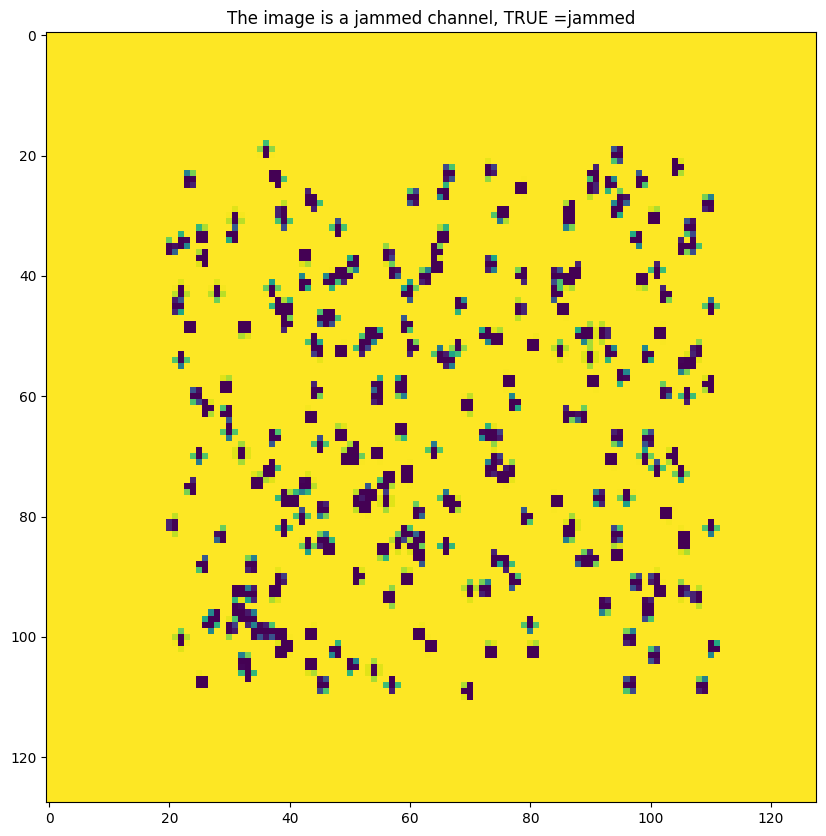

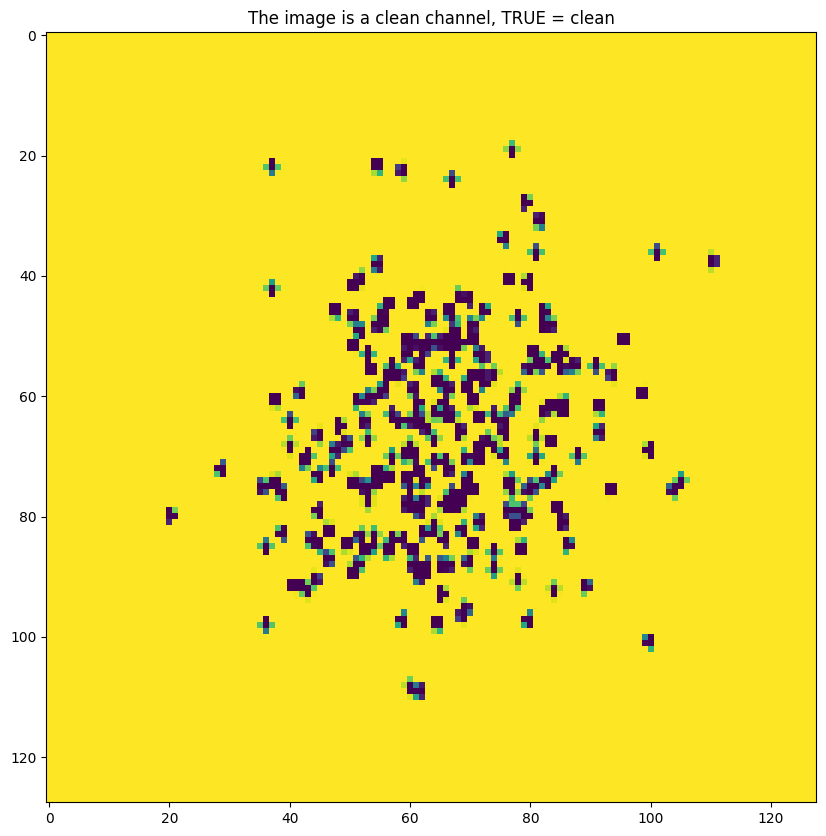

In [17]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [18]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [21]:
values_th=np.arange(min_range_th,max_range_th,0.0002) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

56


In [22]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0159


  0%|          | 2/800 [00:00<00:48, 16.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


  0%|          | 4/800 [00:00<00:48, 16.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


  1%|          | 6/800 [00:00<00:45, 17.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0111


  1%|          | 8/800 [00:00<00:47, 16.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


  1%|▏         | 10/800 [00:00<00:48, 16.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0104


  2%|▏         | 12/800 [00:00<00:50, 15.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


  2%|▏         | 14/800 [00:00<00:52, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


  2%|▏         | 16/800 [00:01<00:53, 14.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0105


  2%|▏         | 18/800 [00:01<00:51, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


  2%|▎         | 20/800 [00:01<00:53, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  3%|▎         | 22/800 [00:01<00:52, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0095


  3%|▎         | 24/800 [00:01<00:51, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


  3%|▎         | 26/800 [00:01<00:52, 14.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


  4%|▎         | 28/800 [00:01<00:52, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


  4%|▍         | 30/800 [00:01<00:49, 15.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0155


  4%|▍         | 32/800 [00:02<00:50, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


  4%|▍         | 34/800 [00:02<00:47, 16.01it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0184


  4%|▍         | 36/800 [00:02<00:45, 16.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


  5%|▍         | 38/800 [00:02<00:44, 16.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0155


  5%|▌         | 40/800 [00:02<00:47, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0153


  5%|▌         | 42/800 [00:02<00:46, 16.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


  6%|▌         | 44/800 [00:02<00:46, 16.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0158


  6%|▌         | 46/800 [00:02<00:45, 16.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0108


  6%|▌         | 48/800 [00:03<00:47, 15.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0157


  6%|▋         | 50/800 [00:03<00:48, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


  6%|▋         | 52/800 [00:03<00:49, 15.26it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0163


  7%|▋         | 54/800 [00:03<00:48, 15.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0105


  7%|▋         | 56/800 [00:03<00:53, 14.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


  7%|▋         | 58/800 [00:03<00:51, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


  8%|▊         | 60/800 [00:03<00:49, 14.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


  8%|▊         | 62/800 [00:03<00:46, 15.79it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0181


  8%|▊         | 64/800 [00:04<00:47, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  8%|▊         | 66/800 [00:04<00:47, 15.29it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


  8%|▊         | 68/800 [00:04<00:47, 15.53it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0108


  9%|▉         | 70/800 [00:04<00:45, 16.03it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0111


  9%|▉         | 72/800 [00:04<00:45, 16.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0110


  9%|▉         | 74/800 [00:04<00:45, 15.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0112


 10%|▉         | 76/800 [00:04<00:44, 16.30it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0149


 10%|▉         | 78/800 [00:05<00:50, 14.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0110


 10%|█         | 80/800 [00:05<00:53, 13.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0133


 10%|█         | 82/800 [00:05<00:54, 13.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0103


 10%|█         | 84/800 [00:05<00:57, 12.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0104


 11%|█         | 86/800 [00:05<00:59, 12.03it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0163


 11%|█         | 88/800 [00:05<01:02, 11.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0159


 11%|█▏        | 90/800 [00:06<01:02, 11.36it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0157


 12%|█▏        | 92/800 [00:06<01:03, 11.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 12%|█▏        | 94/800 [00:06<01:02, 11.31it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 12%|█▏        | 96/800 [00:06<01:01, 11.52it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0181


 12%|█▏        | 98/800 [00:06<01:00, 11.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0157


 12%|█▎        | 100/800 [00:06<00:59, 11.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0109


 13%|█▎        | 102/800 [00:07<01:00, 11.53it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0110


 13%|█▎        | 104/800 [00:07<01:05, 10.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 13%|█▎        | 106/800 [00:07<00:59, 11.73it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


 14%|█▎        | 108/800 [00:07<00:53, 13.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0113


 14%|█▍        | 110/800 [00:07<00:49, 13.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0160


 14%|█▍        | 112/800 [00:07<00:49, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 14%|█▍        | 114/800 [00:07<00:46, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0114


 14%|█▍        | 116/800 [00:08<00:44, 15.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0151


 15%|█▍        | 118/800 [00:08<00:43, 15.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0149


 15%|█▌        | 120/800 [00:08<00:42, 15.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 15%|█▌        | 122/800 [00:08<00:41, 16.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0117


 16%|█▌        | 124/800 [00:08<00:40, 16.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0188


 16%|█▌        | 126/800 [00:08<00:40, 16.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 16%|█▌        | 128/800 [00:08<00:43, 15.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


 16%|█▋        | 130/800 [00:08<00:42, 15.78it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0191


 16%|█▋        | 132/800 [00:09<00:41, 16.28it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0186


 17%|█▋        | 134/800 [00:09<00:41, 15.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0121


 17%|█▋        | 136/800 [00:09<00:43, 15.23it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0120


 17%|█▋        | 138/800 [00:09<00:41, 15.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


 18%|█▊        | 140/800 [00:09<00:43, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 18%|█▊        | 142/800 [00:09<00:42, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0169


 18%|█▊        | 144/800 [00:09<00:42, 15.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 18%|█▊        | 146/800 [00:09<00:41, 15.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 18%|█▊        | 148/800 [00:10<00:40, 15.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0111


 19%|█▉        | 150/800 [00:10<00:40, 16.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 19%|█▉        | 152/800 [00:10<00:39, 16.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 19%|█▉        | 154/800 [00:10<00:41, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 20%|█▉        | 156/800 [00:10<00:40, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 20%|█▉        | 158/800 [00:10<00:39, 16.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0110


 20%|██        | 160/800 [00:10<00:40, 15.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 20%|██        | 162/800 [00:11<00:41, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 20%|██        | 164/800 [00:11<00:40, 15.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0113


 21%|██        | 166/800 [00:11<00:40, 15.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 21%|██        | 168/800 [00:11<00:41, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 21%|██▏       | 170/800 [00:11<00:41, 15.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 22%|██▏       | 172/800 [00:11<00:41, 15.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0142


 22%|██▏       | 174/800 [00:11<00:40, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 22%|██▏       | 176/800 [00:11<00:39, 15.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0113


 22%|██▏       | 178/800 [00:12<00:38, 16.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 22%|██▎       | 180/800 [00:12<00:39, 15.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 23%|██▎       | 182/800 [00:12<00:40, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0161


 23%|██▎       | 184/800 [00:12<00:39, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0113


 23%|██▎       | 186/800 [00:12<00:39, 15.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 24%|██▎       | 188/800 [00:12<00:40, 15.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 24%|██▍       | 190/800 [00:12<00:39, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 24%|██▍       | 192/800 [00:12<00:39, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 24%|██▍       | 194/800 [00:13<00:38, 15.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 24%|██▍       | 196/800 [00:13<00:37, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0107


 25%|██▍       | 198/800 [00:13<00:37, 16.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 25%|██▌       | 200/800 [00:13<00:37, 15.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 25%|██▌       | 202/800 [00:13<00:38, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 26%|██▌       | 204/800 [00:13<00:38, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 26%|██▌       | 206/800 [00:13<00:39, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 26%|██▌       | 208/800 [00:13<00:38, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 26%|██▋       | 210/800 [00:14<00:38, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0153


 26%|██▋       | 212/800 [00:14<00:38, 15.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0154


 27%|██▋       | 214/800 [00:14<00:38, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 27%|██▋       | 216/800 [00:14<00:38, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 27%|██▋       | 218/800 [00:14<00:38, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


 28%|██▊       | 220/800 [00:14<00:38, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0091


 28%|██▊       | 222/800 [00:14<00:38, 14.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 28%|██▊       | 224/800 [00:15<00:38, 15.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0122


 28%|██▊       | 226/800 [00:15<00:36, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0152


 28%|██▊       | 228/800 [00:15<00:37, 15.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


 29%|██▉       | 230/800 [00:15<00:37, 15.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 29%|██▉       | 232/800 [00:15<00:38, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


 29%|██▉       | 234/800 [00:15<00:37, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 30%|██▉       | 236/800 [00:15<00:36, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 30%|██▉       | 238/800 [00:15<00:36, 15.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 30%|███       | 240/800 [00:16<00:35, 15.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0104


 30%|███       | 242/800 [00:16<00:35, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 30%|███       | 244/800 [00:16<00:35, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 31%|███       | 246/800 [00:16<00:35, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 31%|███       | 248/800 [00:16<00:35, 15.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 31%|███▏      | 250/800 [00:16<00:35, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 32%|███▏      | 252/800 [00:16<00:36, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0108


 32%|███▏      | 254/800 [00:16<00:36, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 32%|███▏      | 256/800 [00:17<00:36, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 32%|███▏      | 258/800 [00:17<00:35, 15.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0156


 32%|███▎      | 260/800 [00:17<00:36, 14.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0156


 33%|███▎      | 262/800 [00:17<00:38, 13.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0111


 33%|███▎      | 264/800 [00:17<00:40, 13.21it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0109


 33%|███▎      | 266/800 [00:17<00:44, 12.13it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0183


 34%|███▎      | 268/800 [00:18<00:44, 11.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0161


 34%|███▍      | 270/800 [00:18<00:43, 12.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0158


 34%|███▍      | 272/800 [00:18<00:44, 11.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0111


 34%|███▍      | 274/800 [00:18<00:45, 11.49it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0183


 34%|███▍      | 276/800 [00:18<00:45, 11.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0167


 35%|███▍      | 278/800 [00:18<00:45, 11.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0145


 35%|███▌      | 280/800 [00:19<00:45, 11.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 35%|███▌      | 282/800 [00:19<00:44, 11.57it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0107


 36%|███▌      | 284/800 [00:19<00:45, 11.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 36%|███▌      | 286/800 [00:19<00:44, 11.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0110


 36%|███▌      | 288/800 [00:19<00:43, 11.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0115


 36%|███▋      | 290/800 [00:19<00:39, 12.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


 36%|███▋      | 292/800 [00:20<00:38, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 37%|███▋      | 294/800 [00:20<00:36, 13.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 37%|███▋      | 296/800 [00:20<00:35, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 37%|███▋      | 298/800 [00:20<00:33, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 38%|███▊      | 300/800 [00:20<00:35, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0115


 38%|███▊      | 302/800 [00:20<00:34, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 38%|███▊      | 304/800 [00:20<00:33, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


 38%|███▊      | 306/800 [00:21<00:32, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0150


 38%|███▊      | 308/800 [00:21<00:32, 15.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 39%|███▉      | 310/800 [00:21<00:33, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 39%|███▉      | 312/800 [00:21<00:32, 15.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 39%|███▉      | 314/800 [00:21<00:31, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 40%|███▉      | 316/800 [00:21<00:31, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0148


 40%|███▉      | 318/800 [00:21<00:31, 15.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0115


 40%|████      | 320/800 [00:21<00:31, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 40%|████      | 322/800 [00:22<00:31, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 40%|████      | 324/800 [00:22<00:31, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 41%|████      | 326/800 [00:22<00:31, 14.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 41%|████      | 328/800 [00:22<00:31, 15.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0105


 41%|████▏     | 330/800 [00:22<00:30, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0112


 42%|████▏     | 332/800 [00:22<00:30, 15.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 42%|████▏     | 334/800 [00:22<00:30, 15.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0163


 42%|████▏     | 336/800 [00:22<00:31, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 42%|████▏     | 338/800 [00:23<00:30, 15.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 42%|████▎     | 340/800 [00:23<00:30, 15.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0161


 43%|████▎     | 342/800 [00:23<00:29, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 43%|████▎     | 344/800 [00:23<00:29, 15.52it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 43%|████▎     | 346/800 [00:23<00:29, 15.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0151


 44%|████▎     | 348/800 [00:23<00:29, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0104


 44%|████▍     | 350/800 [00:23<00:29, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


 44%|████▍     | 352/800 [00:24<00:29, 15.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 44%|████▍     | 354/800 [00:24<00:29, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 44%|████▍     | 356/800 [00:24<00:29, 14.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 45%|████▍     | 358/800 [00:24<00:29, 15.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 45%|████▌     | 360/800 [00:24<00:30, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0107


 45%|████▌     | 362/800 [00:24<00:29, 14.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0115


 46%|████▌     | 364/800 [00:24<00:29, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 46%|████▌     | 366/800 [00:24<00:28, 15.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0107


 46%|████▌     | 368/800 [00:25<00:27, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 46%|████▋     | 370/800 [00:25<00:27, 15.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0110


 46%|████▋     | 372/800 [00:25<00:27, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0115


 47%|████▋     | 374/800 [00:25<00:27, 15.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 47%|████▋     | 376/800 [00:25<00:28, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 47%|████▋     | 378/800 [00:25<00:28, 14.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0153


 48%|████▊     | 380/800 [00:25<00:28, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 48%|████▊     | 382/800 [00:26<00:28, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 48%|████▊     | 384/800 [00:26<00:28, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 48%|████▊     | 386/800 [00:26<00:27, 14.95it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0144


 48%|████▊     | 388/800 [00:26<00:27, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 49%|████▉     | 390/800 [00:26<00:27, 14.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0144


 49%|████▉     | 392/800 [00:26<00:27, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 49%|████▉     | 394/800 [00:26<00:28, 14.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0155


 50%|████▉     | 396/800 [00:26<00:28, 14.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0154


 50%|████▉     | 398/800 [00:27<00:27, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 50%|█████     | 400/800 [00:27<00:27, 14.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0152


 50%|█████     | 402/800 [00:27<00:26, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 50%|█████     | 404/800 [00:27<00:26, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 51%|█████     | 406/800 [00:27<00:26, 14.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0150


 51%|█████     | 408/800 [00:27<00:25, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0115


 51%|█████▏    | 410/800 [00:27<00:25, 15.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0113


 52%|█████▏    | 412/800 [00:28<00:25, 15.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 52%|█████▏    | 414/800 [00:28<00:24, 15.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 52%|█████▏    | 416/800 [00:28<00:24, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 52%|█████▏    | 418/800 [00:28<00:25, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 52%|█████▎    | 420/800 [00:28<00:25, 15.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 53%|█████▎    | 422/800 [00:28<00:25, 14.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 53%|█████▎    | 424/800 [00:28<00:26, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 53%|█████▎    | 426/800 [00:28<00:24, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0112


 54%|█████▎    | 428/800 [00:29<00:24, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 54%|█████▍    | 430/800 [00:29<00:24, 15.16it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0112


 54%|█████▍    | 432/800 [00:29<00:24, 15.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 54%|█████▍    | 434/800 [00:29<00:24, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0115


 55%|█████▍    | 436/800 [00:29<00:23, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 55%|█████▍    | 438/800 [00:29<00:23, 15.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0154


 55%|█████▌    | 440/800 [00:29<00:25, 13.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0151


 55%|█████▌    | 442/800 [00:30<00:27, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 56%|█████▌    | 444/800 [00:30<00:28, 12.60it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0108


 56%|█████▌    | 446/800 [00:30<00:28, 12.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0118


 56%|█████▌    | 448/800 [00:30<00:29, 11.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0107


 56%|█████▋    | 450/800 [00:30<00:30, 11.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0192


 56%|█████▋    | 452/800 [00:30<00:30, 11.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 57%|█████▋    | 454/800 [00:31<00:29, 11.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 57%|█████▋    | 456/800 [00:31<00:29, 11.85it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 57%|█████▋    | 458/800 [00:31<00:29, 11.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0112


 57%|█████▊    | 460/800 [00:31<00:29, 11.70it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0118


 58%|█████▊    | 462/800 [00:31<00:29, 11.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0117


 58%|█████▊    | 464/800 [00:32<00:29, 11.56it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0189


 58%|█████▊    | 466/800 [00:32<00:29, 11.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


 58%|█████▊    | 468/800 [00:32<00:28, 11.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 59%|█████▉    | 470/800 [00:32<00:26, 12.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 59%|█████▉    | 472/800 [00:32<00:24, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0155


 59%|█████▉    | 474/800 [00:32<00:23, 13.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 60%|█████▉    | 476/800 [00:32<00:24, 13.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0165


 60%|█████▉    | 478/800 [00:33<00:22, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0105


 60%|██████    | 480/800 [00:33<00:22, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 60%|██████    | 482/800 [00:33<00:21, 14.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0154


 60%|██████    | 484/800 [00:33<00:22, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0160


 61%|██████    | 486/800 [00:33<00:22, 13.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0191


 61%|██████    | 488/800 [00:33<00:22, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0113


 61%|██████▏   | 490/800 [00:33<00:22, 13.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 62%|██████▏   | 492/800 [00:34<00:21, 14.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0190


 62%|██████▏   | 494/800 [00:34<00:20, 14.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 62%|██████▏   | 496/800 [00:34<00:20, 15.12it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0154


 62%|██████▏   | 498/800 [00:34<00:19, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 62%|██████▎   | 500/800 [00:34<00:19, 15.54it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0183


 63%|██████▎   | 502/800 [00:34<00:19, 15.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0147


 63%|██████▎   | 504/800 [00:34<00:19, 15.38it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0114


 63%|██████▎   | 506/800 [00:34<00:19, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 64%|██████▎   | 508/800 [00:35<00:19, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0108


 64%|██████▍   | 510/800 [00:35<00:19, 15.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 64%|██████▍   | 512/800 [00:35<00:19, 15.02it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0179


 64%|██████▍   | 514/800 [00:35<00:18, 15.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 64%|██████▍   | 516/800 [00:35<00:18, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0109


 65%|██████▍   | 518/800 [00:35<00:18, 15.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0110


 65%|██████▌   | 520/800 [00:35<00:18, 15.22it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0191


 65%|██████▌   | 522/800 [00:35<00:17, 15.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 66%|██████▌   | 524/800 [00:36<00:17, 15.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 66%|██████▌   | 526/800 [00:36<00:17, 15.25it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0110


 66%|██████▌   | 528/800 [00:36<00:17, 15.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 66%|██████▋   | 530/800 [00:36<00:18, 14.67it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0184


 66%|██████▋   | 532/800 [00:36<00:18, 14.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 67%|██████▋   | 534/800 [00:36<00:18, 14.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0151


 67%|██████▋   | 536/800 [00:36<00:18, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 67%|██████▋   | 538/800 [00:37<00:17, 14.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 68%|██████▊   | 540/800 [00:37<00:17, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 68%|██████▊   | 542/800 [00:37<00:17, 14.89it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0110


 68%|██████▊   | 544/800 [00:37<00:17, 14.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 68%|██████▊   | 546/800 [00:37<00:17, 14.66it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0110


 68%|██████▊   | 548/800 [00:37<00:16, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 69%|██████▉   | 550/800 [00:37<00:16, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 69%|██████▉   | 552/800 [00:37<00:16, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 69%|██████▉   | 554/800 [00:38<00:16, 14.91it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 70%|██████▉   | 556/800 [00:38<00:16, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0162


 70%|██████▉   | 558/800 [00:38<00:15, 15.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 70%|███████   | 560/800 [00:38<00:15, 15.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 70%|███████   | 562/800 [00:38<00:15, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


 70%|███████   | 564/800 [00:38<00:15, 15.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0150


 71%|███████   | 566/800 [00:38<00:16, 14.47it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0161


 71%|███████   | 568/800 [00:39<00:27,  8.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0153


 71%|███████▏  | 570/800 [00:39<00:23,  9.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0148


 72%|███████▏  | 572/800 [00:39<00:22, 10.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0160


 72%|███████▏  | 574/800 [00:39<00:20, 10.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0153


 72%|███████▏  | 576/800 [00:40<00:19, 11.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0144


 72%|███████▏  | 578/800 [00:40<00:18, 11.97it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0157


 72%|███████▎  | 580/800 [00:40<00:17, 12.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0111


 73%|███████▎  | 582/800 [00:40<00:17, 12.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0114


 73%|███████▎  | 584/800 [00:40<00:16, 12.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 73%|███████▎  | 586/800 [00:40<00:16, 13.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0160


 74%|███████▎  | 588/800 [00:40<00:15, 13.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0188


 74%|███████▍  | 590/800 [00:41<00:16, 12.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0162


 74%|███████▍  | 592/800 [00:41<00:15, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


 74%|███████▍  | 594/800 [00:41<00:15, 12.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0188


 74%|███████▍  | 596/800 [00:41<00:15, 13.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0106


 75%|███████▍  | 598/800 [00:41<00:14, 13.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0105


 75%|███████▌  | 600/800 [00:41<00:14, 13.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 75%|███████▌  | 602/800 [00:41<00:14, 13.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 76%|███████▌  | 604/800 [00:42<00:15, 12.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0188


 76%|███████▌  | 606/800 [00:42<00:14, 13.17it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0153


 76%|███████▌  | 608/800 [00:42<00:15, 12.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0184


 76%|███████▋  | 610/800 [00:42<00:17, 10.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0186


 76%|███████▋  | 612/800 [00:42<00:18, 10.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0147


 77%|███████▋  | 614/800 [00:43<00:17, 10.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 77%|███████▋  | 616/800 [00:43<00:16, 11.23it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 77%|███████▋  | 618/800 [00:43<00:16, 11.31it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0180


 78%|███████▊  | 620/800 [00:43<00:16, 10.81it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0183


 78%|███████▊  | 622/800 [00:43<00:16, 10.47it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0103


 78%|███████▊  | 624/800 [00:44<00:17, 10.29it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0182


 78%|███████▊  | 626/800 [00:44<00:16, 10.34it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0111


 78%|███████▊  | 628/800 [00:44<00:16, 10.32it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0110


 79%|███████▉  | 630/800 [00:44<00:16, 10.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0185


 79%|███████▉  | 632/800 [00:44<00:15, 10.69it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0157


 79%|███████▉  | 634/800 [00:44<00:15, 10.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0116


 80%|███████▉  | 636/800 [00:45<00:15, 10.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0144


 80%|███████▉  | 638/800 [00:45<00:14, 11.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0187


 80%|████████  | 640/800 [00:45<00:14, 11.42it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0161


 80%|████████  | 642/800 [00:45<00:14, 11.12it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0191


 80%|████████  | 644/800 [00:45<00:14, 10.92it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0142


 81%|████████  | 646/800 [00:46<00:13, 11.11it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0184


 81%|████████  | 648/800 [00:46<00:13, 11.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 81%|████████▏ | 650/800 [00:46<00:13, 11.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 82%|████████▏ | 652/800 [00:46<00:12, 11.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 82%|████████▏ | 654/800 [00:46<00:13, 11.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0156


 82%|████████▏ | 656/800 [00:46<00:12, 11.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0110


 82%|████████▏ | 658/800 [00:47<00:12, 11.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0146


 82%|████████▎ | 660/800 [00:47<00:11, 11.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0152


 83%|████████▎ | 662/800 [00:47<00:11, 12.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0107


 83%|████████▎ | 664/800 [00:47<00:11, 12.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 83%|████████▎ | 666/800 [00:47<00:11, 12.00it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0159


 84%|████████▎ | 668/800 [00:47<00:11, 11.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 84%|████████▍ | 670/800 [00:48<00:11, 11.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 84%|████████▍ | 672/800 [00:48<00:10, 11.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 84%|████████▍ | 674/800 [00:48<00:10, 12.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 84%|████████▍ | 676/800 [00:48<00:09, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0142


 85%|████████▍ | 678/800 [00:48<00:08, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


 85%|████████▌ | 680/800 [00:48<00:08, 13.98it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0185


 85%|████████▌ | 682/800 [00:48<00:08, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 86%|████████▌ | 684/800 [00:49<00:07, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0142


 86%|████████▌ | 686/800 [00:49<00:07, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 86%|████████▌ | 688/800 [00:49<00:07, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 86%|████████▋ | 690/800 [00:49<00:07, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0111


 86%|████████▋ | 692/800 [00:49<00:07, 14.86it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0185


 87%|████████▋ | 694/800 [00:49<00:07, 14.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 87%|████████▋ | 696/800 [00:49<00:06, 15.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 87%|████████▋ | 698/800 [00:49<00:06, 15.10it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 88%|████████▊ | 700/800 [00:50<00:06, 15.02it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0185


 88%|████████▊ | 702/800 [00:50<00:06, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0110


 88%|████████▊ | 704/800 [00:50<00:06, 14.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0108


 88%|████████▊ | 706/800 [00:50<00:06, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0142


 88%|████████▊ | 708/800 [00:50<00:06, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0166


 89%|████████▉ | 710/800 [00:50<00:06, 14.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0161


 89%|████████▉ | 712/800 [00:50<00:06, 14.52it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 89%|████████▉ | 714/800 [00:51<00:05, 14.70it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0153


 90%|████████▉ | 716/800 [00:51<00:05, 15.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 90%|████████▉ | 718/800 [00:51<00:05, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 90%|█████████ | 720/800 [00:51<00:05, 15.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0154


 90%|█████████ | 722/800 [00:51<00:05, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0114


 90%|█████████ | 724/800 [00:51<00:05, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 91%|█████████ | 726/800 [00:51<00:05, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0147


 91%|█████████ | 728/800 [00:52<00:05, 14.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0107


 91%|█████████▏| 730/800 [00:52<00:04, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 92%|█████████▏| 732/800 [00:52<00:04, 14.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0155


 92%|█████████▏| 734/800 [00:52<00:04, 14.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0152


 92%|█████████▏| 736/800 [00:52<00:04, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


 92%|█████████▏| 738/800 [00:52<00:04, 14.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0155


 92%|█████████▎| 740/800 [00:52<00:04, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 93%|█████████▎| 742/800 [00:52<00:03, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 93%|█████████▎| 744/800 [00:53<00:03, 14.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 93%|█████████▎| 746/800 [00:53<00:03, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 94%|█████████▎| 748/800 [00:53<00:03, 14.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0111


 94%|█████████▍| 750/800 [00:53<00:03, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 94%|█████████▍| 752/800 [00:53<00:03, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 94%|█████████▍| 754/800 [00:53<00:03, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


 94%|█████████▍| 756/800 [00:53<00:02, 14.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0119


 95%|█████████▍| 758/800 [00:54<00:02, 14.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0190


 95%|█████████▌| 760/800 [00:54<00:02, 15.15it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0117


 95%|█████████▌| 762/800 [00:54<00:02, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 96%|█████████▌| 764/800 [00:54<00:02, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0116


 96%|█████████▌| 766/800 [00:54<00:02, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 96%|█████████▌| 768/800 [00:54<00:02, 14.78it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0155


 96%|█████████▋| 770/800 [00:54<00:02, 14.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 96%|█████████▋| 772/800 [00:55<00:01, 14.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


 97%|█████████▋| 774/800 [00:55<00:02, 12.83it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0111


 97%|█████████▋| 776/800 [00:55<00:01, 12.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0116


 97%|█████████▋| 778/800 [00:55<00:01, 11.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0158


 98%|█████████▊| 780/800 [00:55<00:01, 11.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0161


 98%|█████████▊| 782/800 [00:55<00:01, 11.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 98%|█████████▊| 784/800 [00:56<00:01, 12.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0114


 98%|█████████▊| 786/800 [00:56<00:01, 11.87it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0108


 98%|█████████▊| 788/800 [00:56<00:01, 11.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0155


 99%|█████████▉| 790/800 [00:56<00:00, 11.59it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0186


 99%|█████████▉| 792/800 [00:56<00:00, 11.48it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 99%|█████████▉| 794/800 [00:56<00:00, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0147


100%|█████████▉| 796/800 [00:57<00:00, 11.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0112


100%|█████████▉| 798/800 [00:57<00:00, 11.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0141


100%|██████████| 800/800 [00:57<00:00, 13.91it/s]

800


In [23]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [24]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [25]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0225, 0.08625, 0.2025, 0.33, 0.43625, 0.48, 0.49625]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.49875, 0.49875, 0.49625, 0.49625, 0.495, 0.49375, 0.48375, 0.46625, 0.43875, 0.4025, 0.3475, 0.31125, 0.2825, 0.26375, 0.255, 0.25125, 0.25, 0.25, 0.25, 0.25, 0.25, 0.24875, 0.24875, 0.24625, 0.24375, 0.24125, 0.2325, 0.22875, 0.215, 0.20625, 0.19, 0.15875, 0.1175, 0.08875, 0.055, 0.0325, 0.015, 0.0125, 0.00625, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


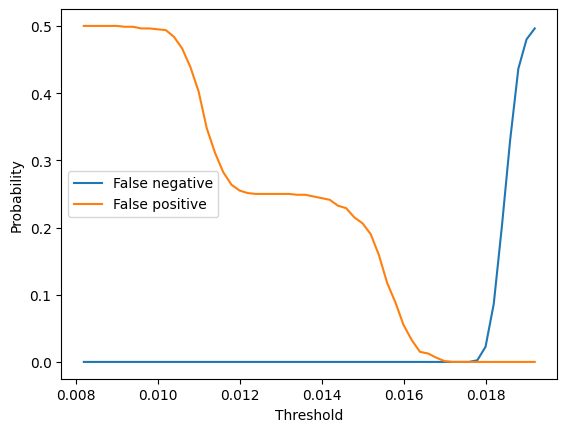

In [26]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [27]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0159


  0%|          | 2/800 [00:00<00:51, 15.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0189


  0%|          | 4/800 [00:00<00:50, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


  1%|          | 6/800 [00:00<00:50, 15.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0111


  1%|          | 8/800 [00:00<00:49, 15.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0155


  1%|▏         | 10/800 [00:00<00:50, 15.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0104


  2%|▏         | 12/800 [00:00<00:48, 16.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0191


  2%|▏         | 14/800 [00:00<00:50, 15.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0157


  2%|▏         | 16/800 [00:01<00:50, 15.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0105


  2%|▏         | 18/800 [00:01<00:50, 15.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0154


  2%|▎         | 20/800 [00:01<00:49, 15.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


  3%|▎         | 22/800 [00:01<00:49, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0095


  3%|▎         | 24/800 [00:01<00:50, 15.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


  3%|▎         | 26/800 [00:01<00:48, 16.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


  4%|▎         | 28/800 [00:01<00:46, 16.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  4%|▍         | 30/800 [00:01<00:46, 16.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


  4%|▍         | 32/800 [00:02<00:47, 16.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


  4%|▍         | 34/800 [00:02<00:48, 15.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  4%|▍         | 36/800 [00:02<00:49, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


  5%|▍         | 38/800 [00:02<00:50, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


  5%|▌         | 40/800 [00:02<00:49, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0153


  5%|▌         | 42/800 [00:02<00:47, 16.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


  6%|▌         | 44/800 [00:02<00:45, 16.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


  6%|▌         | 46/800 [00:02<00:47, 16.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


  6%|▌         | 48/800 [00:03<00:46, 16.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


  6%|▋         | 50/800 [00:03<00:47, 15.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


  6%|▋         | 52/800 [00:03<00:47, 15.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


  7%|▋         | 54/800 [00:03<00:46, 16.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0105


  7%|▋         | 56/800 [00:03<00:48, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


  7%|▋         | 58/800 [00:03<00:46, 15.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0110


  8%|▊         | 60/800 [00:03<00:46, 15.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


  8%|▊         | 62/800 [00:03<00:47, 15.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


  8%|▊         | 64/800 [00:04<00:48, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  8%|▊         | 66/800 [00:04<00:48, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


  8%|▊         | 68/800 [00:04<00:46, 15.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0108


  9%|▉         | 70/800 [00:04<00:48, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0111


  9%|▉         | 72/800 [00:04<00:47, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0110


  9%|▉         | 74/800 [00:04<00:46, 15.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0112


 10%|▉         | 76/800 [00:04<00:46, 15.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0149


 10%|▉         | 78/800 [00:04<00:46, 15.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 10%|█         | 80/800 [00:05<00:46, 15.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0133


 10%|█         | 82/800 [00:05<00:47, 15.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0103


 10%|█         | 84/800 [00:05<00:48, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0104


 11%|█         | 86/800 [00:05<00:49, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0163


 11%|█         | 88/800 [00:05<00:49, 14.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0159


 11%|█▏        | 90/800 [00:05<00:50, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


 12%|█▏        | 92/800 [00:05<00:50, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 12%|█▏        | 94/800 [00:06<00:50, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 12%|█▏        | 96/800 [00:06<00:48, 14.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 12%|█▏        | 98/800 [00:06<00:48, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


 12%|█▎        | 100/800 [00:06<00:49, 14.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0109


 13%|█▎        | 102/800 [00:06<00:49, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0110


 13%|█▎        | 104/800 [00:06<00:47, 14.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0186


 13%|█▎        | 106/800 [00:06<00:47, 14.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 14%|█▎        | 108/800 [00:07<00:48, 14.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0113


 14%|█▍        | 110/800 [00:07<00:48, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


 14%|█▍        | 112/800 [00:07<00:47, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 14%|█▍        | 114/800 [00:07<00:46, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0114


 14%|█▍        | 116/800 [00:07<00:47, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0151


 15%|█▍        | 118/800 [00:07<00:47, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0149


 15%|█▌        | 120/800 [00:07<00:45, 15.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0184


 15%|█▌        | 122/800 [00:08<00:48, 13.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0117


 16%|█▌        | 124/800 [00:08<00:51, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


 16%|█▌        | 126/800 [00:08<00:52, 12.80it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0182


 16%|█▌        | 128/800 [00:08<00:52, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0108


 16%|█▋        | 130/800 [00:08<00:51, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0191


 16%|█▋        | 132/800 [00:08<00:50, 13.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 17%|█▋        | 134/800 [00:08<00:50, 13.31it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0121


 17%|█▋        | 136/800 [00:09<00:50, 13.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0120


 17%|█▋        | 138/800 [00:09<00:53, 12.31it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0108


 18%|█▊        | 140/800 [00:09<00:58, 11.33it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0181


 18%|█▊        | 142/800 [00:09<00:58, 11.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0169


 18%|█▊        | 144/800 [00:09<00:57, 11.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 18%|█▊        | 146/800 [00:10<00:56, 11.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0110


 18%|█▊        | 148/800 [00:10<00:56, 11.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0111


 19%|█▉        | 150/800 [00:10<00:53, 12.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 19%|█▉        | 152/800 [00:10<00:50, 12.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 19%|█▉        | 154/800 [00:10<00:47, 13.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 20%|█▉        | 156/800 [00:10<00:46, 13.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 20%|█▉        | 158/800 [00:10<00:44, 14.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0110


 20%|██        | 160/800 [00:11<00:43, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 20%|██        | 162/800 [00:11<00:41, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 20%|██        | 164/800 [00:11<00:42, 15.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0113


 21%|██        | 166/800 [00:11<00:41, 15.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 21%|██        | 168/800 [00:11<00:40, 15.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 21%|██▏       | 170/800 [00:11<00:41, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 22%|██▏       | 172/800 [00:11<00:39, 15.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0142


 22%|██▏       | 174/800 [00:11<00:38, 16.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 22%|██▏       | 176/800 [00:12<00:40, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0113


 22%|██▏       | 178/800 [00:12<00:40, 15.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 22%|██▎       | 180/800 [00:12<00:39, 15.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 23%|██▎       | 182/800 [00:12<00:40, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


 23%|██▎       | 184/800 [00:12<00:39, 15.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0113


 23%|██▎       | 186/800 [00:12<00:41, 14.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 24%|██▎       | 188/800 [00:12<00:39, 15.35it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


 24%|██▍       | 190/800 [00:12<00:38, 15.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 24%|██▍       | 192/800 [00:13<00:38, 15.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 24%|██▍       | 194/800 [00:13<00:37, 16.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 24%|██▍       | 196/800 [00:13<00:37, 16.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0107


 25%|██▍       | 198/800 [00:13<00:38, 15.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 25%|██▌       | 200/800 [00:13<00:37, 15.96it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0189


 25%|██▌       | 202/800 [00:13<00:38, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 26%|██▌       | 204/800 [00:13<00:38, 15.67it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0181


 26%|██▌       | 206/800 [00:13<00:36, 16.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 26%|██▌       | 208/800 [00:14<00:36, 16.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 26%|██▋       | 210/800 [00:14<00:36, 15.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0153


 26%|██▋       | 212/800 [00:14<00:36, 15.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 27%|██▋       | 214/800 [00:14<00:37, 15.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 27%|██▋       | 216/800 [00:14<00:37, 15.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0163


 27%|██▋       | 218/800 [00:14<00:37, 15.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0158


 28%|██▊       | 220/800 [00:14<00:36, 16.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0091


 28%|██▊       | 222/800 [00:14<00:36, 15.99it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0187


 28%|██▊       | 224/800 [00:15<00:35, 16.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0122


 28%|██▊       | 226/800 [00:15<00:35, 16.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 28%|██▊       | 228/800 [00:15<00:35, 15.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0190


 29%|██▉       | 230/800 [00:15<00:36, 15.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 29%|██▉       | 232/800 [00:15<00:37, 15.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0108


 29%|██▉       | 234/800 [00:15<00:37, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 30%|██▉       | 236/800 [00:15<00:36, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 30%|██▉       | 238/800 [00:15<00:36, 15.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 30%|███       | 240/800 [00:16<00:37, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0104


 30%|███       | 242/800 [00:16<00:37, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 30%|███       | 244/800 [00:16<00:38, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 31%|███       | 246/800 [00:16<00:38, 14.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 31%|███       | 248/800 [00:16<00:37, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 31%|███▏      | 250/800 [00:16<00:37, 14.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 32%|███▏      | 252/800 [00:16<00:36, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


 32%|███▏      | 254/800 [00:17<00:35, 15.37it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 32%|███▏      | 256/800 [00:17<00:36, 14.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 32%|███▏      | 258/800 [00:17<00:37, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0156


 32%|███▎      | 260/800 [00:17<00:36, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0156


 33%|███▎      | 262/800 [00:17<00:36, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0111


 33%|███▎      | 264/800 [00:17<00:37, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0109


 33%|███▎      | 266/800 [00:17<00:36, 14.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 34%|███▎      | 268/800 [00:18<00:36, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0161


 34%|███▍      | 270/800 [00:18<00:35, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


 34%|███▍      | 272/800 [00:18<00:35, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0111


 34%|███▍      | 274/800 [00:18<00:35, 14.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 34%|███▍      | 276/800 [00:18<00:34, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0167


 35%|███▍      | 278/800 [00:18<00:34, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0145


 35%|███▌      | 280/800 [00:18<00:33, 15.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 35%|███▌      | 282/800 [00:18<00:34, 15.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0107


 36%|███▌      | 284/800 [00:19<00:33, 15.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 36%|███▌      | 286/800 [00:19<00:33, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 36%|███▌      | 288/800 [00:19<00:32, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0115


 36%|███▋      | 290/800 [00:19<00:31, 16.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0160


 36%|███▋      | 292/800 [00:19<00:32, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 37%|███▋      | 294/800 [00:19<00:32, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 37%|███▋      | 296/800 [00:19<00:32, 15.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0118


 37%|███▋      | 298/800 [00:19<00:32, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0156


 38%|███▊      | 300/800 [00:20<00:33, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0115


 38%|███▊      | 302/800 [00:20<00:32, 15.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 38%|███▊      | 304/800 [00:20<00:32, 15.20it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0160


 38%|███▊      | 306/800 [00:20<00:36, 13.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0150


 38%|███▊      | 308/800 [00:20<00:37, 13.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 39%|███▉      | 310/800 [00:20<00:37, 13.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 39%|███▉      | 312/800 [00:21<00:37, 13.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 39%|███▉      | 314/800 [00:21<00:38, 12.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 40%|███▉      | 316/800 [00:21<00:38, 12.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0148


 40%|███▉      | 318/800 [00:21<00:39, 12.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0115


 40%|████      | 320/800 [00:21<00:39, 12.06it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 40%|████      | 322/800 [00:21<00:39, 12.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 40%|████      | 324/800 [00:22<00:39, 12.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 41%|████      | 326/800 [00:22<00:40, 11.77it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0186


 41%|████      | 328/800 [00:22<00:40, 11.57it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0105


 41%|████▏     | 330/800 [00:22<00:40, 11.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0112


 42%|████▏     | 332/800 [00:22<00:38, 12.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 42%|████▏     | 334/800 [00:22<00:37, 12.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 42%|████▏     | 336/800 [00:22<00:34, 13.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0154


 42%|████▏     | 338/800 [00:23<00:32, 14.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 42%|████▎     | 340/800 [00:23<00:33, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


 43%|████▎     | 342/800 [00:23<00:31, 14.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 43%|████▎     | 344/800 [00:23<00:31, 14.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 43%|████▎     | 346/800 [00:23<00:30, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0151


 44%|████▎     | 348/800 [00:23<00:29, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0104


 44%|████▍     | 350/800 [00:23<00:29, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


 44%|████▍     | 352/800 [00:24<00:29, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 44%|████▍     | 354/800 [00:24<00:28, 15.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 44%|████▍     | 356/800 [00:24<00:28, 15.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 45%|████▍     | 358/800 [00:24<00:29, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 45%|████▌     | 360/800 [00:24<00:29, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0107


 45%|████▌     | 362/800 [00:24<00:29, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0115


 46%|████▌     | 364/800 [00:24<00:28, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 46%|████▌     | 366/800 [00:24<00:28, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0107


 46%|████▌     | 368/800 [00:25<00:28, 15.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 46%|████▋     | 370/800 [00:25<00:28, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 46%|████▋     | 372/800 [00:25<00:27, 15.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0115


 47%|████▋     | 374/800 [00:25<00:27, 15.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 47%|████▋     | 376/800 [00:25<00:27, 15.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 47%|████▋     | 378/800 [00:25<00:28, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0153


 48%|████▊     | 380/800 [00:25<00:27, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 48%|████▊     | 382/800 [00:26<00:26, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 48%|████▊     | 384/800 [00:26<00:26, 15.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 48%|████▊     | 386/800 [00:26<00:26, 15.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0144


 48%|████▊     | 388/800 [00:26<00:27, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 49%|████▉     | 390/800 [00:26<00:27, 14.99it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0144


 49%|████▉     | 392/800 [00:26<00:26, 15.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 49%|████▉     | 394/800 [00:26<00:26, 15.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0155


 50%|████▉     | 396/800 [00:26<00:26, 15.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0154


 50%|████▉     | 398/800 [00:27<00:26, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 50%|█████     | 400/800 [00:27<00:26, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 50%|█████     | 402/800 [00:27<00:25, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 50%|█████     | 404/800 [00:27<00:25, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 51%|█████     | 406/800 [00:27<00:25, 15.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0150


 51%|█████     | 408/800 [00:27<00:26, 14.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0115


 51%|█████▏    | 410/800 [00:27<00:25, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 52%|█████▏    | 412/800 [00:27<00:26, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 52%|█████▏    | 414/800 [00:28<00:25, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 52%|█████▏    | 416/800 [00:28<00:25, 15.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 52%|█████▏    | 418/800 [00:28<00:24, 15.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 52%|█████▎    | 420/800 [00:28<00:24, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 53%|█████▎    | 422/800 [00:28<00:25, 15.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 53%|█████▎    | 424/800 [00:28<00:24, 15.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 53%|█████▎    | 426/800 [00:28<00:23, 15.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0112


 54%|█████▎    | 428/800 [00:29<00:24, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 54%|█████▍    | 430/800 [00:29<00:24, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0112


 54%|█████▍    | 432/800 [00:29<00:24, 15.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 54%|█████▍    | 434/800 [00:29<00:24, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0115


 55%|█████▍    | 436/800 [00:29<00:24, 15.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 55%|█████▍    | 438/800 [00:29<00:23, 15.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0154


 55%|█████▌    | 440/800 [00:29<00:24, 14.98it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0151


 55%|█████▌    | 442/800 [00:29<00:24, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0190


 56%|█████▌    | 444/800 [00:30<00:24, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0108


 56%|█████▌    | 446/800 [00:30<00:24, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0118


 56%|█████▌    | 448/800 [00:30<00:24, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0107


 56%|█████▋    | 450/800 [00:30<00:24, 14.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


 56%|█████▋    | 452/800 [00:30<00:24, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 57%|█████▋    | 454/800 [00:30<00:23, 14.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 57%|█████▋    | 456/800 [00:30<00:23, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 57%|█████▋    | 458/800 [00:31<00:23, 14.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0112


 57%|█████▊    | 460/800 [00:31<00:23, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 58%|█████▊    | 462/800 [00:31<00:22, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0117


 58%|█████▊    | 464/800 [00:31<00:23, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 58%|█████▊    | 466/800 [00:31<00:22, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0116


 58%|█████▊    | 468/800 [00:31<00:22, 14.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 59%|█████▉    | 470/800 [00:31<00:22, 14.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0160


 59%|█████▉    | 472/800 [00:32<00:23, 14.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0155


 59%|█████▉    | 474/800 [00:32<00:22, 14.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 60%|█████▉    | 476/800 [00:32<00:21, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0165


 60%|█████▉    | 478/800 [00:32<00:21, 14.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0105


 60%|██████    | 480/800 [00:32<00:21, 14.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 60%|██████    | 482/800 [00:32<00:21, 14.72it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0154


 60%|██████    | 484/800 [00:32<00:21, 14.50it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0160


 61%|██████    | 486/800 [00:33<00:24, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0191


 61%|██████    | 488/800 [00:33<00:25, 12.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0113


 61%|██████▏   | 490/800 [00:33<00:25, 12.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 62%|██████▏   | 492/800 [00:33<00:26, 11.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0190


 62%|██████▏   | 494/800 [00:33<00:27, 11.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 62%|██████▏   | 496/800 [00:33<00:26, 11.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0154


 62%|██████▏   | 498/800 [00:34<00:26, 11.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0182


 62%|██████▎   | 500/800 [00:34<00:26, 11.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 63%|██████▎   | 502/800 [00:34<00:26, 11.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0147


 63%|██████▎   | 504/800 [00:34<00:26, 11.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0114


 63%|██████▎   | 506/800 [00:34<00:25, 11.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 64%|██████▎   | 508/800 [00:35<00:26, 11.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0108


 64%|██████▍   | 510/800 [00:35<00:26, 10.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 64%|██████▍   | 512/800 [00:35<00:25, 11.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 64%|██████▍   | 514/800 [00:35<00:24, 11.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 64%|██████▍   | 516/800 [00:35<00:22, 12.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0109


 65%|██████▍   | 518/800 [00:35<00:21, 13.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0110


 65%|██████▌   | 520/800 [00:35<00:20, 13.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0191


 65%|██████▌   | 522/800 [00:36<00:19, 14.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 66%|██████▌   | 524/800 [00:36<00:18, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 66%|██████▌   | 526/800 [00:36<00:19, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 66%|██████▌   | 528/800 [00:36<00:18, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 66%|██████▋   | 530/800 [00:36<00:18, 14.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 66%|██████▋   | 532/800 [00:36<00:18, 14.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 67%|██████▋   | 534/800 [00:36<00:17, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0151


 67%|██████▋   | 536/800 [00:36<00:17, 14.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 67%|██████▋   | 538/800 [00:37<00:17, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 68%|██████▊   | 540/800 [00:37<00:17, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 68%|██████▊   | 542/800 [00:37<00:17, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0110


 68%|██████▊   | 544/800 [00:37<00:16, 15.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 68%|██████▊   | 546/800 [00:37<00:16, 14.95it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0110


 68%|██████▊   | 548/800 [00:37<00:16, 15.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 69%|██████▉   | 550/800 [00:37<00:16, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 69%|██████▉   | 552/800 [00:38<00:17, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 69%|██████▉   | 554/800 [00:38<00:17, 14.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 70%|██████▉   | 556/800 [00:38<00:16, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0162


 70%|██████▉   | 558/800 [00:38<00:16, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 70%|███████   | 560/800 [00:38<00:16, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 70%|███████   | 562/800 [00:38<00:16, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0108


 70%|███████   | 564/800 [00:38<00:15, 14.81it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0150


 71%|███████   | 566/800 [00:39<00:15, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0161


 71%|███████   | 568/800 [00:39<00:15, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0153


 71%|███████▏  | 570/800 [00:39<00:15, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0148


 72%|███████▏  | 572/800 [00:39<00:14, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 72%|███████▏  | 574/800 [00:39<00:14, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0153


 72%|███████▏  | 576/800 [00:39<00:14, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0144


 72%|███████▏  | 578/800 [00:39<00:14, 14.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


 72%|███████▎  | 580/800 [00:39<00:14, 15.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0111


 73%|███████▎  | 582/800 [00:40<00:14, 14.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0114


 73%|███████▎  | 584/800 [00:40<00:14, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 73%|███████▎  | 586/800 [00:40<00:14, 14.81it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0160


 74%|███████▎  | 588/800 [00:40<00:14, 14.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 74%|███████▍  | 590/800 [00:40<00:14, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0162


 74%|███████▍  | 592/800 [00:40<00:13, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 74%|███████▍  | 594/800 [00:40<00:13, 15.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 74%|███████▍  | 596/800 [00:40<00:13, 15.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0106


 75%|███████▍  | 598/800 [00:41<00:12, 15.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0105


 75%|███████▌  | 600/800 [00:41<00:13, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 75%|███████▌  | 602/800 [00:41<00:13, 14.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 76%|███████▌  | 604/800 [00:41<00:13, 14.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0188


 76%|███████▌  | 606/800 [00:41<00:12, 14.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0153


 76%|███████▌  | 608/800 [00:41<00:12, 15.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 76%|███████▋  | 610/800 [00:41<00:12, 15.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 76%|███████▋  | 612/800 [00:42<00:12, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 77%|███████▋  | 614/800 [00:42<00:12, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 77%|███████▋  | 616/800 [00:42<00:12, 14.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 77%|███████▋  | 618/800 [00:42<00:12, 14.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 78%|███████▊  | 620/800 [00:42<00:12, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 78%|███████▊  | 622/800 [00:42<00:12, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0103


 78%|███████▊  | 624/800 [00:42<00:12, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 78%|███████▊  | 626/800 [00:43<00:11, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0111


 78%|███████▊  | 628/800 [00:43<00:11, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 79%|███████▉  | 630/800 [00:43<00:11, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 79%|███████▉  | 632/800 [00:43<00:11, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 79%|███████▉  | 634/800 [00:43<00:10, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0116


 80%|███████▉  | 636/800 [00:43<00:10, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0144


 80%|███████▉  | 638/800 [00:43<00:10, 15.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 80%|████████  | 640/800 [00:43<00:10, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0161


 80%|████████  | 642/800 [00:44<00:10, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0191


 80%|████████  | 644/800 [00:44<00:10, 14.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0142


 81%|████████  | 646/800 [00:44<00:10, 14.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 81%|████████  | 648/800 [00:44<00:10, 14.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 81%|████████▏ | 650/800 [00:44<00:10, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 82%|████████▏ | 652/800 [00:44<00:10, 14.77it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0186


 82%|████████▏ | 654/800 [00:44<00:09, 14.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0156


 82%|████████▏ | 656/800 [00:45<00:16,  8.69it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0110


 82%|████████▏ | 658/800 [00:45<00:15,  8.94it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0146


 82%|████████▎ | 660/800 [00:45<00:14,  9.40it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0152


 83%|████████▎ | 662/800 [00:45<00:14,  9.68it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0107


 83%|████████▎ | 664/800 [00:46<00:13, 10.00it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0184


 83%|████████▎ | 666/800 [00:46<00:13, 10.02it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0159


 84%|████████▎ | 668/800 [00:46<00:13, 10.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 84%|████████▍ | 670/800 [00:46<00:12, 10.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 84%|████████▍ | 672/800 [00:46<00:12, 10.44it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0185


 84%|████████▍ | 674/800 [00:47<00:11, 10.78it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0189


 84%|████████▍ | 676/800 [00:47<00:11, 10.80it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0142


 85%|████████▍ | 678/800 [00:47<00:11, 10.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0116


 85%|████████▌ | 680/800 [00:47<00:11, 10.59it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0185


 85%|████████▌ | 682/800 [00:47<00:11, 10.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0113


 86%|████████▌ | 684/800 [00:48<00:10, 10.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0142


 86%|████████▌ | 686/800 [00:48<00:10, 11.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 86%|████████▌ | 688/800 [00:48<00:09, 11.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 86%|████████▋ | 690/800 [00:48<00:09, 11.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0111


 86%|████████▋ | 692/800 [00:48<00:08, 12.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 87%|████████▋ | 694/800 [00:48<00:08, 12.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 87%|████████▋ | 696/800 [00:48<00:07, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 87%|████████▋ | 698/800 [00:49<00:07, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 88%|████████▊ | 700/800 [00:49<00:07, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 88%|████████▊ | 702/800 [00:49<00:07, 13.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0110


 88%|████████▊ | 704/800 [00:49<00:07, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0108


 88%|████████▊ | 706/800 [00:49<00:07, 13.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0142


 88%|████████▊ | 708/800 [00:49<00:06, 13.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0166


 89%|████████▉ | 710/800 [00:49<00:06, 13.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0161


 89%|████████▉ | 712/800 [00:50<00:06, 13.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 89%|████████▉ | 714/800 [00:50<00:06, 13.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0153


 90%|████████▉ | 716/800 [00:50<00:06, 13.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 90%|████████▉ | 718/800 [00:50<00:06, 12.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 90%|█████████ | 720/800 [00:50<00:06, 12.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 90%|█████████ | 722/800 [00:50<00:06, 12.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 90%|█████████ | 724/800 [00:51<00:05, 13.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 91%|█████████ | 726/800 [00:51<00:05, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0147


 91%|█████████ | 728/800 [00:51<00:05, 13.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0107


 91%|█████████▏| 730/800 [00:51<00:05, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 92%|█████████▏| 732/800 [00:51<00:05, 13.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0155


 92%|█████████▏| 734/800 [00:51<00:04, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0152


 92%|█████████▏| 736/800 [00:51<00:04, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0159


 92%|█████████▏| 738/800 [00:52<00:04, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0155


 92%|█████████▎| 740/800 [00:52<00:04, 14.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0156


 93%|█████████▎| 742/800 [00:52<00:04, 13.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 93%|█████████▎| 744/800 [00:52<00:03, 14.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 93%|█████████▎| 746/800 [00:52<00:03, 13.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0163


 94%|█████████▎| 748/800 [00:52<00:03, 13.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0111


 94%|█████████▍| 750/800 [00:52<00:03, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 94%|█████████▍| 752/800 [00:53<00:03, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 94%|█████████▍| 754/800 [00:53<00:03, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0095


 94%|█████████▍| 756/800 [00:53<00:03, 13.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0119


 95%|█████████▍| 758/800 [00:53<00:02, 14.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0190


 95%|█████████▌| 760/800 [00:53<00:02, 13.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0117


 95%|█████████▌| 762/800 [00:53<00:02, 13.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 96%|█████████▌| 764/800 [00:53<00:02, 13.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


 96%|█████████▌| 766/800 [00:54<00:02, 14.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 96%|█████████▌| 768/800 [00:54<00:02, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 96%|█████████▋| 770/800 [00:54<00:02, 14.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 96%|█████████▋| 772/800 [00:54<00:01, 14.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 97%|█████████▋| 774/800 [00:54<00:01, 14.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0111


 97%|█████████▋| 776/800 [00:54<00:01, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 97%|█████████▋| 778/800 [00:54<00:01, 14.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0158


 98%|█████████▊| 780/800 [00:54<00:01, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0161


 98%|█████████▊| 782/800 [00:55<00:01, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 98%|█████████▊| 784/800 [00:55<00:01, 14.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0114


 98%|█████████▊| 786/800 [00:55<00:00, 14.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0108


 98%|█████████▊| 788/800 [00:55<00:00, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0155


 99%|█████████▉| 790/800 [00:55<00:00, 14.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 99%|█████████▉| 792/800 [00:55<00:00, 14.62it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 99%|█████████▉| 794/800 [00:55<00:00, 14.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0147


100%|█████████▉| 796/800 [00:56<00:00, 15.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0112


100%|█████████▉| 798/800 [00:56<00:00, 14.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0141


100%|██████████| 800/800 [00:56<00:00, 14.20it/s]


In [28]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 90.25 %


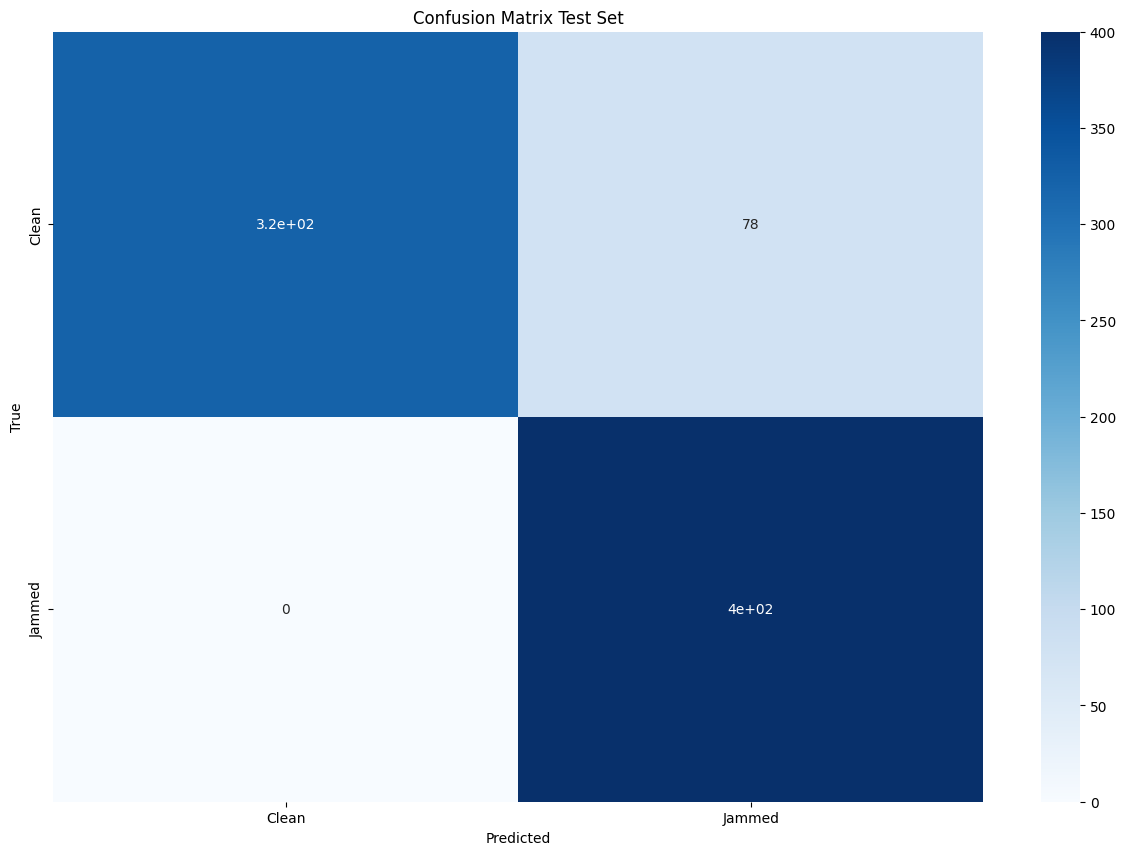

In [29]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold